In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from adamw import AdamW
from nadam import Nadam
from uoptim import UOptimizer


from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from utils_exp import plot_graphs

import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PATH = './fMNIST_data'

In [2]:
train_data = datasets.FashionMNIST(PATH, train=True, download=True, transform=transforms.ToTensor())

# calculate statistics for fashion MNIST
global_norm_mean = train_data.train_data.float().div(255).mean().item()
global_norm_std = train_data.train_data.float().div(255).std().item()

In [3]:
# util to create loaders
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((global_norm_mean,), (global_norm_std,)),
           ])

def mnist(batch_size=50, valid=0, shuffle=True, transform=mnist_transform, path=PATH):
    test_data = datasets.FashionMNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_data = datasets.FashionMNIST(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader


def plot_mnist(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

In [4]:
train_loader, valid_loader, test_loader = mnist(valid=10000)

In [5]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU()):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [6]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [7]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, optim_type='UAdam', **optim_params):
        super(Net, self).__init__()
        
        self._conv1 = ConvLayer([1, 16, 3], bn=batchnorm)
        self._conv2 = ConvLayer([16, 32, 3], bn=batchnorm, activation_fn=nn.Sigmoid())
        
        self.fc = FullyConnected([32*7*7, 10], dropout=dropout)
        
        self._loss = None
        
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
        elif optim_type == 'AdamW':
            self.optim = AdamW(self.parameters(), **optim_params)
        elif optim_type == 'Nadam':
            self.optim = Nadam(self.parameters(), **optim_params)
        elif optim_type == 'Adamax':
            self.optim = optim.Adamax(self.parameters(), **optim_params)
        elif optim_type == 'UOptimizer':
            self.optim = UOptimizer(params = self.parameters(), **optim_params)
    
    def conv(self, x):
        x = self._conv1(x)
        x = self._conv2(x)
        return x
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 32*7*7)
        x = self.fc(x)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.cross_entropy(output, target, **kwargs)
        self._correct = output.data.max(1, keepdim=True)[1]
        self._correct = self._correct.eq(target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [8]:
models = {
          # testing correctness of SGD
          'SGD': Net(True, False, 'SGD', lr=1e-3).to(device), 
          'UOSGD': Net(True, False, 'UOptimizer', lr=1e-3).to(device), 
    
          'SGD_momentum':Net(True, False, 'SGD', momentum=0.9, lr=1e-3).to(device),
          'UOSGD_momentum':Net(True, False, 'UOptimizer', use_exp_avg_norm = True, beta1_dump=0, lr=1e-3).to(device),
    
          'SGD_momentum_n':Net(True, False, 'SGD', momentum=0.9, nesterov=True,  lr=1e-3).to(device),
          'UOSGD_momentum_n':Net(True, False, 'UOptimizer', use_exp_avg_norm = True, beta1_dump=0,
                                 exp_avg_norm_type='nesterov', lr=1e-3).to(device),
    
          # testing RMSProp      
          'RMSProp': Net(True, False, 'RMSProp', lr=1e-4).to(device), 
          'UORMSProp': Net(True, False, 'UOptimizer', use_exp_avg_sq_norm = True,  lr=1e-4).to(device), 
          
          # testing Adadelta
          'Adadelta':Net(True, False, 'Adadelta', lr=1).to(device),
          'UOAdadelta':Net(True, False, 'UOptimizer', use_exp_avg_sq_norm = True, use_adadelta_lr=True, lr=1).to(device),
            
          # testing adam-like algoritms. 
          'Adam': Net(True, False, 'Adam', lr=1e-4).to(device), 
          'UOAdam': Net(True, False, 'UOptimizer', use_exp_avg_norm=True, 
                        use_exp_avg_sq_norm = True, use_bias_correction= True, lr=1e-4).to(device), 
    
          'Amsgrad':Net(True, False, 'Adam', lr=1e-4, amsgrad=True).to(device),
          'UOAmsgrad':Net(True, False, 'UOptimizer', use_exp_avg_norm=True, use_exp_avg_sq_norm = True, 
                            use_bias_correction=True, exp_avg_sq_norm_type='max_past_sq', lr=1e-4).to(device), 
          
          # AdamW is not included in Pytorch, so I used fastai implementation from here:
          # https://github.com/anandsaha/fastai.part1.v2/commit/159e1712e60f299e11c42caab35c726f367bcd61
          'AdamW':Net(True, False, 'AdamW', lr=1e-4, weight_decay=0.00025).to(device),
          'UOAdamW':Net(True, False, 'UOptimizer', use_exp_avg_norm=True, use_exp_avg_sq_norm = True, 
                        use_bias_correction= True, decouple_wd=True, lr=1e-4, weight_decay=0.00025).to(device),
    
          # Please note that pytorch Nadam is the official Nadam implementation for Keras translated to PyTorch
          # I use the classical Nadam formulas, so the results could be differ
          'Nadam':Net(True, False, 'Nadam', lr=1e-4).to(device),
          'UONadam':Net(True, False, 'UOptimizer', use_exp_avg_norm=True, use_exp_avg_sq_norm = True, 
                            use_bias_correction= True,exp_avg_norm_type='nesterov',  lr=1e-4).to(device),
          
          'Adamax':Net(True, False, 'Adamax', lr=1e-4).to(device),
          'UOAdamax':Net(True, False, 'UOptimizer', use_exp_avg_norm=True, use_exp_avg_sq_norm = True, 
                        use_bias_correction= True, exp_avg_sq_norm_type ='infinite_l', lr=1e-4).to(device),
    
    
          # create exotic combinations for fun
          'Adam_with_adadelta_coeff':Net(True, False, 'UOptimizer', 
                                         use_exp_avg_norm = True,
                                         use_exp_avg_sq_norm = True,
                                         use_adadelta_lr = True,
                                         use_bias_correction = True,
                                         lr=1).to(device),
          'Adam_with_exp_avg_norm_like_sgd':Net(True, False, 'UOptimizer', 
                                         use_exp_avg_norm = True,
                                         use_exp_avg_sq_norm = True,
                                         use_bias_correction = True,
                                         beta1_dump=0,
                                         lr=1e-4).to(device),                  
            }
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

You are using the AdamW optimizer


In [9]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [10]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], target, size_average=False).item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [11]:
n_epoch = 100
for epoch in range(1, n_epoch+1):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses SGD: 2.3440 UOSGD: 2.3566 SGD_momentum: 2.3131 UOSGD_momentum: 2.3867 SGD_momentum_n: 2.2397 UOSGD_momentum_n: 2.3286 RMSProp: 2.4062 UORMSProp: 2.3350 Adadelta: 2.3744 UOAdadelta: 2.3515 Adam: 2.3114 UOAdam: 2.3117 Amsgrad: 2.3177 UOAmsgrad: 2.3572 AdamW: 2.2842 UOAdamW: 2.3104 Nadam: 2.3083 UONadam: 2.3320 Adamax: 2.3701 UOAdamax: 2.4289 Adam_with_adadelta_coeff: 2.3005 Adam_with_exp_avg_norm_like_sgd: 2.3757
Train Epoch: 1 [10000/50000 (20%)]	Losses SGD: 2.1724 UOSGD: 2.1834 SGD_momentum: 1.3908 UOSGD_momentum: 1.3240 SGD_momentum_n: 1.3532 UOSGD_momentum_n: 1.3703 RMSProp: 1.4942 UORMSProp: 1.0436 Adadelta: 0.6499 UOAdadelta: 0.4998 Adam: 1.6599 UOAdam: 1.7725 Amsgrad: 1.6693 UOAmsgrad: 1.7882 AdamW: 1.7151 UOAdamW: 1.7465 Nadam: 1.0171 UONadam: 1.8023 Adamax: 2.0833 UOAdamax: 2.0451 Adam_with_adadelta_coeff: 1.4422 Adam_with_exp_avg_norm_like_sgd: 0.6292
Train Epoch: 1 [20000/50000 (40%)]	Losses SGD: 2.0607 UOSGD: 2.1046 SGD_momentum: 0.9791 UO

Train Epoch: 3 [0/50000 (0%)]	Losses SGD: 1.3316 UOSGD: 1.4777 SGD_momentum: 0.4813 UOSGD_momentum: 0.4289 SGD_momentum_n: 0.4217 UOSGD_momentum_n: 0.4302 RMSProp: 0.5067 UORMSProp: 0.4279 Adadelta: 0.1587 UOAdadelta: 0.1673 Adam: 0.5190 UOAdam: 0.5596 Amsgrad: 0.5543 UOAmsgrad: 0.5998 AdamW: 0.7699 UOAdamW: 0.7611 Nadam: 0.5169 UONadam: 0.5818 Adamax: 0.8925 UOAdamax: 0.8396 Adam_with_adadelta_coeff: 0.3578 Adam_with_exp_avg_norm_like_sgd: 0.1661
Train Epoch: 3 [10000/50000 (20%)]	Losses SGD: 1.2341 UOSGD: 1.3754 SGD_momentum: 0.4096 UOSGD_momentum: 0.4049 SGD_momentum_n: 0.4325 UOSGD_momentum_n: 0.4139 RMSProp: 0.4337 UORMSProp: 0.3941 Adadelta: 0.2294 UOAdadelta: 0.2595 Adam: 0.4341 UOAdam: 0.4798 Amsgrad: 0.4706 UOAmsgrad: 0.4897 AdamW: 0.6634 UOAdamW: 0.6568 Nadam: 0.4467 UONadam: 0.4829 Adamax: 0.7505 UOAdamax: 0.7143 Adam_with_adadelta_coeff: 0.3895 Adam_with_exp_avg_norm_like_sgd: 0.3347
Train Epoch: 3 [20000/50000 (40%)]	Losses SGD: 1.2339 UOSGD: 1.3899 SGD_momentum: 0.4433 UO

Train Epoch: 5 [0/50000 (0%)]	Losses SGD: 0.9794 UOSGD: 1.1030 SGD_momentum: 0.4098 UOSGD_momentum: 0.4341 SGD_momentum_n: 0.4519 UOSGD_momentum_n: 0.4541 RMSProp: 0.4459 UORMSProp: 0.4189 Adadelta: 0.1587 UOAdadelta: 0.1944 Adam: 0.4606 UOAdam: 0.5027 Amsgrad: 0.4943 UOAmsgrad: 0.5299 AdamW: 0.7084 UOAdamW: 0.7257 Nadam: 0.5860 UONadam: 0.5041 Adamax: 0.6890 UOAdamax: 0.6605 Adam_with_adadelta_coeff: 0.3392 Adam_with_exp_avg_norm_like_sgd: 0.1963
Train Epoch: 5 [10000/50000 (20%)]	Losses SGD: 0.9713 UOSGD: 1.0576 SGD_momentum: 0.4226 UOSGD_momentum: 0.4128 SGD_momentum_n: 0.4025 UOSGD_momentum_n: 0.4191 RMSProp: 0.4411 UORMSProp: 0.4377 Adadelta: 0.1289 UOAdadelta: 0.1369 Adam: 0.4444 UOAdam: 0.4837 Amsgrad: 0.4747 UOAmsgrad: 0.5225 AdamW: 0.7296 UOAdamW: 0.7378 Nadam: 0.5714 UONadam: 0.5103 Adamax: 0.6899 UOAdamax: 0.6584 Adam_with_adadelta_coeff: 0.3276 Adam_with_exp_avg_norm_like_sgd: 0.1515
Train Epoch: 5 [20000/50000 (40%)]	Losses SGD: 0.8945 UOSGD: 1.0025 SGD_momentum: 0.3312 UO

Train Epoch: 7 [0/50000 (0%)]	Losses SGD: 0.7297 UOSGD: 0.8151 SGD_momentum: 0.2837 UOSGD_momentum: 0.3048 SGD_momentum_n: 0.2832 UOSGD_momentum_n: 0.3190 RMSProp: 0.2961 UORMSProp: 0.2792 Adadelta: 0.2405 UOAdadelta: 0.2192 Adam: 0.3050 UOAdam: 0.3596 Amsgrad: 0.3450 UOAmsgrad: 0.3323 AdamW: 0.6099 UOAdamW: 0.6172 Nadam: 0.4484 UONadam: 0.3074 Adamax: 0.4684 UOAdamax: 0.4407 Adam_with_adadelta_coeff: 0.2470 Adam_with_exp_avg_norm_like_sgd: 0.2185
Train Epoch: 7 [10000/50000 (20%)]	Losses SGD: 0.8776 UOSGD: 0.9293 SGD_momentum: 0.4391 UOSGD_momentum: 0.4463 SGD_momentum_n: 0.4769 UOSGD_momentum_n: 0.4450 RMSProp: 0.4506 UORMSProp: 0.4147 Adadelta: 0.2152 UOAdadelta: 0.2506 Adam: 0.4416 UOAdam: 0.4517 Amsgrad: 0.4893 UOAmsgrad: 0.4874 AdamW: 0.7556 UOAdamW: 0.7664 Nadam: 0.5922 UONadam: 0.4487 Adamax: 0.6268 UOAdamax: 0.5928 Adam_with_adadelta_coeff: 0.3784 Adam_with_exp_avg_norm_like_sgd: 0.2609
Train Epoch: 7 [20000/50000 (40%)]	Losses SGD: 0.7909 UOSGD: 0.8416 SGD_momentum: 0.3009 UO

Train Epoch: 9 [0/50000 (0%)]	Losses SGD: 0.6389 UOSGD: 0.7008 SGD_momentum: 0.3207 UOSGD_momentum: 0.3371 SGD_momentum_n: 0.3231 UOSGD_momentum_n: 0.3386 RMSProp: 0.3239 UORMSProp: 0.2979 Adadelta: 0.2385 UOAdadelta: 0.2693 Adam: 0.3104 UOAdam: 0.2911 Amsgrad: 0.3279 UOAmsgrad: 0.3363 AdamW: 0.6210 UOAdamW: 0.6118 Nadam: 0.4651 UONadam: 0.3060 Adamax: 0.4174 UOAdamax: 0.4138 Adam_with_adadelta_coeff: 0.2949 Adam_with_exp_avg_norm_like_sgd: 0.2616
Train Epoch: 9 [10000/50000 (20%)]	Losses SGD: 0.6995 UOSGD: 0.7191 SGD_momentum: 0.3474 UOSGD_momentum: 0.3485 SGD_momentum_n: 0.3332 UOSGD_momentum_n: 0.3433 RMSProp: 0.3382 UORMSProp: 0.3391 Adadelta: 0.2025 UOAdadelta: 0.2814 Adam: 0.3376 UOAdam: 0.3543 Amsgrad: 0.3733 UOAmsgrad: 0.3765 AdamW: 0.6518 UOAdamW: 0.6422 Nadam: 0.4839 UONadam: 0.3309 Adamax: 0.4672 UOAdamax: 0.4359 Adam_with_adadelta_coeff: 0.3088 Adam_with_exp_avg_norm_like_sgd: 0.2617
Train Epoch: 9 [20000/50000 (40%)]	Losses SGD: 0.6437 UOSGD: 0.6963 SGD_momentum: 0.3003 UO

Train Epoch: 11 [0/50000 (0%)]	Losses SGD: 0.6695 UOSGD: 0.7125 SGD_momentum: 0.2548 UOSGD_momentum: 0.2482 SGD_momentum_n: 0.2947 UOSGD_momentum_n: 0.2810 RMSProp: 0.2420 UORMSProp: 0.2384 Adadelta: 0.1560 UOAdadelta: 0.1582 Adam: 0.2423 UOAdam: 0.2379 Amsgrad: 0.2746 UOAmsgrad: 0.3287 AdamW: 0.6584 UOAdamW: 0.6597 Nadam: 0.5313 UONadam: 0.2598 Adamax: 0.4032 UOAdamax: 0.3769 Adam_with_adadelta_coeff: 0.2173 Adam_with_exp_avg_norm_like_sgd: 0.0985
Train Epoch: 11 [10000/50000 (20%)]	Losses SGD: 0.7802 UOSGD: 0.8135 SGD_momentum: 0.4603 UOSGD_momentum: 0.4502 SGD_momentum_n: 0.4312 UOSGD_momentum_n: 0.4122 RMSProp: 0.4289 UORMSProp: 0.4600 Adadelta: 0.2518 UOAdadelta: 0.3617 Adam: 0.4539 UOAdam: 0.4652 Amsgrad: 0.4837 UOAmsgrad: 0.4587 AdamW: 0.7883 UOAdamW: 0.7673 Nadam: 0.6297 UONadam: 0.4317 Adamax: 0.5588 UOAdamax: 0.5529 Adam_with_adadelta_coeff: 0.4485 Adam_with_exp_avg_norm_like_sgd: 0.3015
Train Epoch: 11 [20000/50000 (40%)]	Losses SGD: 0.6348 UOSGD: 0.6876 SGD_momentum: 0.2998

Train Epoch: 13 [0/50000 (0%)]	Losses SGD: 0.5245 UOSGD: 0.5500 SGD_momentum: 0.2645 UOSGD_momentum: 0.2543 SGD_momentum_n: 0.2615 UOSGD_momentum_n: 0.2594 RMSProp: 0.2374 UORMSProp: 0.2485 Adadelta: 0.0687 UOAdadelta: 0.0858 Adam: 0.2815 UOAdam: 0.2643 Amsgrad: 0.2682 UOAmsgrad: 0.2353 AdamW: 0.5812 UOAdamW: 0.5847 Nadam: 0.4571 UONadam: 0.2336 Adamax: 0.3553 UOAdamax: 0.3269 Adam_with_adadelta_coeff: 0.1750 Adam_with_exp_avg_norm_like_sgd: 0.1152
Train Epoch: 13 [10000/50000 (20%)]	Losses SGD: 0.7752 UOSGD: 0.8189 SGD_momentum: 0.4447 UOSGD_momentum: 0.4718 SGD_momentum_n: 0.4200 UOSGD_momentum_n: 0.4609 RMSProp: 0.4588 UORMSProp: 0.4614 Adadelta: 0.2533 UOAdadelta: 0.2615 Adam: 0.4371 UOAdam: 0.4487 Amsgrad: 0.4388 UOAmsgrad: 0.4772 AdamW: 0.7804 UOAdamW: 0.7891 Nadam: 0.6587 UONadam: 0.4755 Adamax: 0.5726 UOAdamax: 0.5600 Adam_with_adadelta_coeff: 0.4435 Adam_with_exp_avg_norm_like_sgd: 0.3160
Train Epoch: 13 [20000/50000 (40%)]	Losses SGD: 0.5080 UOSGD: 0.5306 SGD_momentum: 0.2561

Train Epoch: 15 [0/50000 (0%)]	Losses SGD: 0.4968 UOSGD: 0.5179 SGD_momentum: 0.1884 UOSGD_momentum: 0.2128 SGD_momentum_n: 0.1747 UOSGD_momentum_n: 0.1895 RMSProp: 0.1855 UORMSProp: 0.1860 Adadelta: 0.1088 UOAdadelta: 0.0821 Adam: 0.1679 UOAdam: 0.1840 Amsgrad: 0.2171 UOAmsgrad: 0.2238 AdamW: 0.5642 UOAdamW: 0.5704 Nadam: 0.4277 UONadam: 0.1787 Adamax: 0.2905 UOAdamax: 0.2810 Adam_with_adadelta_coeff: 0.1984 Adam_with_exp_avg_norm_like_sgd: 0.0831
Train Epoch: 15 [10000/50000 (20%)]	Losses SGD: 0.6289 UOSGD: 0.6381 SGD_momentum: 0.2837 UOSGD_momentum: 0.3070 SGD_momentum_n: 0.2853 UOSGD_momentum_n: 0.2913 RMSProp: 0.2867 UORMSProp: 0.2558 Adadelta: 0.2717 UOAdadelta: 0.2388 Adam: 0.3270 UOAdam: 0.2801 Amsgrad: 0.3419 UOAmsgrad: 0.3298 AdamW: 0.6690 UOAdamW: 0.6908 Nadam: 0.5535 UONadam: 0.2688 Adamax: 0.4527 UOAdamax: 0.4323 Adam_with_adadelta_coeff: 0.2756 Adam_with_exp_avg_norm_like_sgd: 0.1326
Train Epoch: 15 [20000/50000 (40%)]	Losses SGD: 0.7985 UOSGD: 0.8389 SGD_momentum: 0.3569

Train Epoch: 17 [0/50000 (0%)]	Losses SGD: 0.6176 UOSGD: 0.6775 SGD_momentum: 0.2359 UOSGD_momentum: 0.2808 SGD_momentum_n: 0.2620 UOSGD_momentum_n: 0.2384 RMSProp: 0.2331 UORMSProp: 0.2339 Adadelta: 0.0952 UOAdadelta: 0.0918 Adam: 0.2513 UOAdam: 0.2258 Amsgrad: 0.2620 UOAmsgrad: 0.2651 AdamW: 0.7081 UOAdamW: 0.6937 Nadam: 0.5928 UONadam: 0.2448 Adamax: 0.3582 UOAdamax: 0.4012 Adam_with_adadelta_coeff: 0.1822 Adam_with_exp_avg_norm_like_sgd: 0.0627
Train Epoch: 17 [10000/50000 (20%)]	Losses SGD: 0.6768 UOSGD: 0.7160 SGD_momentum: 0.2228 UOSGD_momentum: 0.2621 SGD_momentum_n: 0.2357 UOSGD_momentum_n: 0.2291 RMSProp: 0.2565 UORMSProp: 0.2034 Adadelta: 0.0549 UOAdadelta: 0.1040 Adam: 0.2431 UOAdam: 0.1938 Amsgrad: 0.2471 UOAmsgrad: 0.2856 AdamW: 0.7308 UOAdamW: 0.7381 Nadam: 0.6288 UONadam: 0.2112 Adamax: 0.3590 UOAdamax: 0.3782 Adam_with_adadelta_coeff: 0.1967 Adam_with_exp_avg_norm_like_sgd: 0.0779
Train Epoch: 17 [20000/50000 (40%)]	Losses SGD: 0.4501 UOSGD: 0.4800 SGD_momentum: 0.2655

Train Epoch: 19 [0/50000 (0%)]	Losses SGD: 0.4357 UOSGD: 0.4894 SGD_momentum: 0.1429 UOSGD_momentum: 0.1502 SGD_momentum_n: 0.1339 UOSGD_momentum_n: 0.1567 RMSProp: 0.1399 UORMSProp: 0.1405 Adadelta: 0.1652 UOAdadelta: 0.1424 Adam: 0.1288 UOAdam: 0.1309 Amsgrad: 0.1611 UOAmsgrad: 0.1329 AdamW: 0.5898 UOAdamW: 0.5984 Nadam: 0.4137 UONadam: 0.1312 Adamax: 0.2103 UOAdamax: 0.2046 Adam_with_adadelta_coeff: 0.0927 Adam_with_exp_avg_norm_like_sgd: 0.0753
Train Epoch: 19 [10000/50000 (20%)]	Losses SGD: 0.6232 UOSGD: 0.6214 SGD_momentum: 0.1536 UOSGD_momentum: 0.1627 SGD_momentum_n: 0.1753 UOSGD_momentum_n: 0.1626 RMSProp: 0.1429 UORMSProp: 0.1502 Adadelta: 0.0364 UOAdadelta: 0.0743 Adam: 0.1583 UOAdam: 0.1524 Amsgrad: 0.1948 UOAmsgrad: 0.2073 AdamW: 0.6835 UOAdamW: 0.6829 Nadam: 0.5598 UONadam: 0.1197 Adamax: 0.2894 UOAdamax: 0.3099 Adam_with_adadelta_coeff: 0.1151 Adam_with_exp_avg_norm_like_sgd: 0.0527
Train Epoch: 19 [20000/50000 (40%)]	Losses SGD: 0.5180 UOSGD: 0.5331 SGD_momentum: 0.2613

Train Epoch: 21 [0/50000 (0%)]	Losses SGD: 0.4695 UOSGD: 0.5252 SGD_momentum: 0.1665 UOSGD_momentum: 0.2179 SGD_momentum_n: 0.1905 UOSGD_momentum_n: 0.1881 RMSProp: 0.1627 UORMSProp: 0.1727 Adadelta: 0.0546 UOAdadelta: 0.0529 Adam: 0.1546 UOAdam: 0.1821 Amsgrad: 0.2079 UOAmsgrad: 0.2040 AdamW: 0.6433 UOAdamW: 0.6524 Nadam: 0.4875 UONadam: 0.1521 Adamax: 0.2317 UOAdamax: 0.2492 Adam_with_adadelta_coeff: 0.1342 Adam_with_exp_avg_norm_like_sgd: 0.0552
Train Epoch: 21 [10000/50000 (20%)]	Losses SGD: 0.4999 UOSGD: 0.5288 SGD_momentum: 0.1784 UOSGD_momentum: 0.1839 SGD_momentum_n: 0.1673 UOSGD_momentum_n: 0.2091 RMSProp: 0.1806 UORMSProp: 0.1758 Adadelta: 0.0662 UOAdadelta: 0.0786 Adam: 0.1888 UOAdam: 0.1606 Amsgrad: 0.2402 UOAmsgrad: 0.2138 AdamW: 0.6362 UOAdamW: 0.6474 Nadam: 0.4988 UONadam: 0.1873 Adamax: 0.2883 UOAdamax: 0.2973 Adam_with_adadelta_coeff: 0.1588 Adam_with_exp_avg_norm_like_sgd: 0.1290
Train Epoch: 21 [20000/50000 (40%)]	Losses SGD: 0.4753 UOSGD: 0.4850 SGD_momentum: 0.3813

Train Epoch: 23 [0/50000 (0%)]	Losses SGD: 0.3470 UOSGD: 0.3490 SGD_momentum: 0.1590 UOSGD_momentum: 0.1581 SGD_momentum_n: 0.1715 UOSGD_momentum_n: 0.1772 RMSProp: 0.1608 UORMSProp: 0.1629 Adadelta: 0.1069 UOAdadelta: 0.1152 Adam: 0.1851 UOAdam: 0.1507 Amsgrad: 0.1766 UOAmsgrad: 0.1705 AdamW: 0.5117 UOAdamW: 0.5281 Nadam: 0.3497 UONadam: 0.1710 Adamax: 0.2184 UOAdamax: 0.2046 Adam_with_adadelta_coeff: 0.1641 Adam_with_exp_avg_norm_like_sgd: 0.0774
Train Epoch: 23 [10000/50000 (20%)]	Losses SGD: 0.5882 UOSGD: 0.6403 SGD_momentum: 0.3088 UOSGD_momentum: 0.2936 SGD_momentum_n: 0.2728 UOSGD_momentum_n: 0.2928 RMSProp: 0.2286 UORMSProp: 0.2980 Adadelta: 0.0704 UOAdadelta: 0.1826 Adam: 0.2954 UOAdam: 0.2340 Amsgrad: 0.2803 UOAmsgrad: 0.2670 AdamW: 0.7145 UOAdamW: 0.7338 Nadam: 0.6129 UONadam: 0.2292 Adamax: 0.3438 UOAdamax: 0.3672 Adam_with_adadelta_coeff: 0.2558 Adam_with_exp_avg_norm_like_sgd: 0.1730
Train Epoch: 23 [20000/50000 (40%)]	Losses SGD: 0.3221 UOSGD: 0.3257 SGD_momentum: 0.1545

Train Epoch: 25 [0/50000 (0%)]	Losses SGD: 0.5615 UOSGD: 0.5865 SGD_momentum: 0.2235 UOSGD_momentum: 0.2463 SGD_momentum_n: 0.2139 UOSGD_momentum_n: 0.2213 RMSProp: 0.2062 UORMSProp: 0.2098 Adadelta: 0.1312 UOAdadelta: 0.1010 Adam: 0.2174 UOAdam: 0.2031 Amsgrad: 0.2411 UOAmsgrad: 0.2355 AdamW: 0.6532 UOAdamW: 0.6687 Nadam: 0.5667 UONadam: 0.2004 Adamax: 0.3384 UOAdamax: 0.3337 Adam_with_adadelta_coeff: 0.1760 Adam_with_exp_avg_norm_like_sgd: 0.0959
Train Epoch: 25 [10000/50000 (20%)]	Losses SGD: 0.5576 UOSGD: 0.5833 SGD_momentum: 0.2145 UOSGD_momentum: 0.2095 SGD_momentum_n: 0.2086 UOSGD_momentum_n: 0.2303 RMSProp: 0.1478 UORMSProp: 0.1876 Adadelta: 0.1029 UOAdadelta: 0.0666 Adam: 0.1480 UOAdam: 0.1882 Amsgrad: 0.2647 UOAmsgrad: 0.2388 AdamW: 0.7221 UOAdamW: 0.7105 Nadam: 0.5901 UONadam: 0.1978 Adamax: 0.3140 UOAdamax: 0.3320 Adam_with_adadelta_coeff: 0.1636 Adam_with_exp_avg_norm_like_sgd: 0.0934
Train Epoch: 25 [20000/50000 (40%)]	Losses SGD: 0.5018 UOSGD: 0.5326 SGD_momentum: 0.2483

Train Epoch: 27 [0/50000 (0%)]	Losses SGD: 0.6237 UOSGD: 0.6251 SGD_momentum: 0.3417 UOSGD_momentum: 0.2886 SGD_momentum_n: 0.2548 UOSGD_momentum_n: 0.2979 RMSProp: 0.2233 UORMSProp: 0.2280 Adadelta: 0.1205 UOAdadelta: 0.0976 Adam: 0.2830 UOAdam: 0.1868 Amsgrad: 0.2691 UOAmsgrad: 0.3026 AdamW: 0.8183 UOAdamW: 0.8049 Nadam: 0.6667 UONadam: 0.2175 Adamax: 0.3535 UOAdamax: 0.3713 Adam_with_adadelta_coeff: 0.2164 Adam_with_exp_avg_norm_like_sgd: 0.0918
Train Epoch: 27 [10000/50000 (20%)]	Losses SGD: 0.5830 UOSGD: 0.6287 SGD_momentum: 0.3111 UOSGD_momentum: 0.2896 SGD_momentum_n: 0.3321 UOSGD_momentum_n: 0.3444 RMSProp: 0.2514 UORMSProp: 0.3136 Adadelta: 0.0808 UOAdadelta: 0.1391 Adam: 0.3103 UOAdam: 0.2662 Amsgrad: 0.3372 UOAmsgrad: 0.3907 AdamW: 0.7922 UOAdamW: 0.7769 Nadam: 0.6124 UONadam: 0.3437 Adamax: 0.4136 UOAdamax: 0.4031 Adam_with_adadelta_coeff: 0.2847 Adam_with_exp_avg_norm_like_sgd: 0.1155
Train Epoch: 27 [20000/50000 (40%)]	Losses SGD: 0.6159 UOSGD: 0.6193 SGD_momentum: 0.2563

Train Epoch: 29 [0/50000 (0%)]	Losses SGD: 0.5946 UOSGD: 0.5697 SGD_momentum: 0.4240 UOSGD_momentum: 0.4094 SGD_momentum_n: 0.3962 UOSGD_momentum_n: 0.4555 RMSProp: 0.3834 UORMSProp: 0.4802 Adadelta: 0.1585 UOAdadelta: 0.2239 Adam: 0.4227 UOAdam: 0.4905 Amsgrad: 0.4210 UOAmsgrad: 0.4354 AdamW: 0.7438 UOAdamW: 0.7546 Nadam: 0.5935 UONadam: 0.3741 Adamax: 0.4523 UOAdamax: 0.4367 Adam_with_adadelta_coeff: 0.3515 Adam_with_exp_avg_norm_like_sgd: 0.2536
Train Epoch: 29 [10000/50000 (20%)]	Losses SGD: 0.4608 UOSGD: 0.4870 SGD_momentum: 0.2521 UOSGD_momentum: 0.2500 SGD_momentum_n: 0.2357 UOSGD_momentum_n: 0.2334 RMSProp: 0.1833 UORMSProp: 0.1571 Adadelta: 0.0989 UOAdadelta: 0.1544 Adam: 0.1845 UOAdam: 0.1791 Amsgrad: 0.1975 UOAmsgrad: 0.2249 AdamW: 0.6638 UOAdamW: 0.6529 Nadam: 0.5116 UONadam: 0.1749 Adamax: 0.2446 UOAdamax: 0.2337 Adam_with_adadelta_coeff: 0.1452 Adam_with_exp_avg_norm_like_sgd: 0.0953
Train Epoch: 29 [20000/50000 (40%)]	Losses SGD: 0.3570 UOSGD: 0.3657 SGD_momentum: 0.2327

Train Epoch: 31 [0/50000 (0%)]	Losses SGD: 0.4978 UOSGD: 0.5191 SGD_momentum: 0.2928 UOSGD_momentum: 0.2532 SGD_momentum_n: 0.2502 UOSGD_momentum_n: 0.2756 RMSProp: 0.2693 UORMSProp: 0.2453 Adadelta: 0.1959 UOAdadelta: 0.1123 Adam: 0.2613 UOAdam: 0.2776 Amsgrad: 0.2635 UOAmsgrad: 0.2673 AdamW: 0.6967 UOAdamW: 0.6976 Nadam: 0.5685 UONadam: 0.2826 Adamax: 0.2950 UOAdamax: 0.2982 Adam_with_adadelta_coeff: 0.2477 Adam_with_exp_avg_norm_like_sgd: 0.2210
Train Epoch: 31 [10000/50000 (20%)]	Losses SGD: 0.4606 UOSGD: 0.4856 SGD_momentum: 0.1713 UOSGD_momentum: 0.2095 SGD_momentum_n: 0.2073 UOSGD_momentum_n: 0.1758 RMSProp: 0.1836 UORMSProp: 0.2063 Adadelta: 0.0523 UOAdadelta: 0.0332 Adam: 0.2213 UOAdam: 0.1770 Amsgrad: 0.2551 UOAmsgrad: 0.2358 AdamW: 0.6277 UOAdamW: 0.6375 Nadam: 0.5264 UONadam: 0.1796 Adamax: 0.2662 UOAdamax: 0.2763 Adam_with_adadelta_coeff: 0.1278 Adam_with_exp_avg_norm_like_sgd: 0.0453
Train Epoch: 31 [20000/50000 (40%)]	Losses SGD: 0.3996 UOSGD: 0.3898 SGD_momentum: 0.2244

Train Epoch: 33 [0/50000 (0%)]	Losses SGD: 0.5224 UOSGD: 0.5231 SGD_momentum: 0.2693 UOSGD_momentum: 0.2646 SGD_momentum_n: 0.2158 UOSGD_momentum_n: 0.2853 RMSProp: 0.2246 UORMSProp: 0.2064 Adadelta: 0.1192 UOAdadelta: 0.0715 Adam: 0.2271 UOAdam: 0.2381 Amsgrad: 0.2642 UOAmsgrad: 0.2637 AdamW: 0.7750 UOAdamW: 0.7465 Nadam: 0.6276 UONadam: 0.2406 Adamax: 0.3232 UOAdamax: 0.3226 Adam_with_adadelta_coeff: 0.1806 Adam_with_exp_avg_norm_like_sgd: 0.0378
Train Epoch: 33 [10000/50000 (20%)]	Losses SGD: 0.5698 UOSGD: 0.5862 SGD_momentum: 0.2125 UOSGD_momentum: 0.3095 SGD_momentum_n: 0.2870 UOSGD_momentum_n: 0.3066 RMSProp: 0.2163 UORMSProp: 0.1888 Adadelta: 0.1166 UOAdadelta: 0.1142 Adam: 0.1979 UOAdam: 0.2279 Amsgrad: 0.2355 UOAmsgrad: 0.2593 AdamW: 0.7125 UOAdamW: 0.7256 Nadam: 0.6065 UONadam: 0.2419 Adamax: 0.3355 UOAdamax: 0.3546 Adam_with_adadelta_coeff: 0.1607 Adam_with_exp_avg_norm_like_sgd: 0.0699
Train Epoch: 33 [20000/50000 (40%)]	Losses SGD: 0.4096 UOSGD: 0.4375 SGD_momentum: 0.1147

Train Epoch: 35 [0/50000 (0%)]	Losses SGD: 0.4077 UOSGD: 0.4086 SGD_momentum: 0.1563 UOSGD_momentum: 0.1792 SGD_momentum_n: 0.1445 UOSGD_momentum_n: 0.1505 RMSProp: 0.1243 UORMSProp: 0.1261 Adadelta: 0.0331 UOAdadelta: 0.0300 Adam: 0.1199 UOAdam: 0.1218 Amsgrad: 0.1918 UOAmsgrad: 0.2109 AdamW: 0.6180 UOAdamW: 0.6225 Nadam: 0.4310 UONadam: 0.1357 Adamax: 0.2099 UOAdamax: 0.2373 Adam_with_adadelta_coeff: 0.1227 Adam_with_exp_avg_norm_like_sgd: 0.0545
Train Epoch: 35 [10000/50000 (20%)]	Losses SGD: 0.4011 UOSGD: 0.3803 SGD_momentum: 0.2208 UOSGD_momentum: 0.2148 SGD_momentum_n: 0.2232 UOSGD_momentum_n: 0.2428 RMSProp: 0.2469 UORMSProp: 0.1744 Adadelta: 0.0504 UOAdadelta: 0.0841 Adam: 0.1846 UOAdam: 0.1906 Amsgrad: 0.2459 UOAmsgrad: 0.2401 AdamW: 0.6384 UOAdamW: 0.6197 Nadam: 0.4411 UONadam: 0.2144 Adamax: 0.2521 UOAdamax: 0.2633 Adam_with_adadelta_coeff: 0.1782 Adam_with_exp_avg_norm_like_sgd: 0.1469
Train Epoch: 35 [20000/50000 (40%)]	Losses SGD: 0.3146 UOSGD: 0.3174 SGD_momentum: 0.1242

Train Epoch: 37 [0/50000 (0%)]	Losses SGD: 0.4797 UOSGD: 0.4862 SGD_momentum: 0.3225 UOSGD_momentum: 0.3179 SGD_momentum_n: 0.3478 UOSGD_momentum_n: 0.3116 RMSProp: 0.3137 UORMSProp: 0.3323 Adadelta: 0.0683 UOAdadelta: 0.1096 Adam: 0.2519 UOAdam: 0.3021 Amsgrad: 0.3074 UOAmsgrad: 0.3060 AdamW: 0.7136 UOAdamW: 0.7050 Nadam: 0.5543 UONadam: 0.2639 Adamax: 0.3367 UOAdamax: 0.3053 Adam_with_adadelta_coeff: 0.3482 Adam_with_exp_avg_norm_like_sgd: 0.0591
Train Epoch: 37 [10000/50000 (20%)]	Losses SGD: 0.3866 UOSGD: 0.3553 SGD_momentum: 0.2098 UOSGD_momentum: 0.2405 SGD_momentum_n: 0.1852 UOSGD_momentum_n: 0.2507 RMSProp: 0.2069 UORMSProp: 0.1861 Adadelta: 0.0709 UOAdadelta: 0.0563 Adam: 0.2275 UOAdam: 0.1795 Amsgrad: 0.2073 UOAmsgrad: 0.2049 AdamW: 0.5896 UOAdamW: 0.5800 Nadam: 0.4323 UONadam: 0.2343 Adamax: 0.2874 UOAdamax: 0.2553 Adam_with_adadelta_coeff: 0.2424 Adam_with_exp_avg_norm_like_sgd: 0.0874
Train Epoch: 37 [20000/50000 (40%)]	Losses SGD: 0.3993 UOSGD: 0.4011 SGD_momentum: 0.1644

Train Epoch: 39 [0/50000 (0%)]	Losses SGD: 0.3387 UOSGD: 0.3625 SGD_momentum: 0.1164 UOSGD_momentum: 0.1181 SGD_momentum_n: 0.1558 UOSGD_momentum_n: 0.1304 RMSProp: 0.0974 UORMSProp: 0.1050 Adadelta: 0.0713 UOAdadelta: 0.0230 Adam: 0.1417 UOAdam: 0.1262 Amsgrad: 0.1372 UOAmsgrad: 0.1667 AdamW: 0.6099 UOAdamW: 0.6068 Nadam: 0.4433 UONadam: 0.1198 Adamax: 0.2014 UOAdamax: 0.1890 Adam_with_adadelta_coeff: 0.1082 Adam_with_exp_avg_norm_like_sgd: 0.0314
Train Epoch: 39 [10000/50000 (20%)]	Losses SGD: 0.4289 UOSGD: 0.4087 SGD_momentum: 0.2330 UOSGD_momentum: 0.2709 SGD_momentum_n: 0.2647 UOSGD_momentum_n: 0.2290 RMSProp: 0.2012 UORMSProp: 0.2220 Adadelta: 0.0884 UOAdadelta: 0.0726 Adam: 0.2256 UOAdam: 0.2722 Amsgrad: 0.2630 UOAmsgrad: 0.2441 AdamW: 0.7008 UOAdamW: 0.7100 Nadam: 0.5394 UONadam: 0.1787 Adamax: 0.2689 UOAdamax: 0.2534 Adam_with_adadelta_coeff: 0.2107 Adam_with_exp_avg_norm_like_sgd: 0.0878
Train Epoch: 39 [20000/50000 (40%)]	Losses SGD: 0.3309 UOSGD: 0.3195 SGD_momentum: 0.1871

Train Epoch: 41 [0/50000 (0%)]	Losses SGD: 0.4375 UOSGD: 0.4472 SGD_momentum: 0.2251 UOSGD_momentum: 0.2393 SGD_momentum_n: 0.2913 UOSGD_momentum_n: 0.2310 RMSProp: 0.2110 UORMSProp: 0.1711 Adadelta: 0.0277 UOAdadelta: 0.0652 Adam: 0.1950 UOAdam: 0.1983 Amsgrad: 0.2226 UOAmsgrad: 0.2459 AdamW: 0.6662 UOAdamW: 0.6681 Nadam: 0.5500 UONadam: 0.1992 Adamax: 0.2862 UOAdamax: 0.2844 Adam_with_adadelta_coeff: 0.1608 Adam_with_exp_avg_norm_like_sgd: 0.0443
Train Epoch: 41 [10000/50000 (20%)]	Losses SGD: 0.4942 UOSGD: 0.5281 SGD_momentum: 0.3352 UOSGD_momentum: 0.2839 SGD_momentum_n: 0.3416 UOSGD_momentum_n: 0.2927 RMSProp: 0.3181 UORMSProp: 0.3313 Adadelta: 0.0974 UOAdadelta: 0.1666 Adam: 0.2539 UOAdam: 0.2953 Amsgrad: 0.3430 UOAmsgrad: 0.3348 AdamW: 0.7064 UOAdamW: 0.6990 Nadam: 0.5703 UONadam: 0.2620 Adamax: 0.3765 UOAdamax: 0.3472 Adam_with_adadelta_coeff: 0.3112 Adam_with_exp_avg_norm_like_sgd: 0.0471
Train Epoch: 41 [20000/50000 (40%)]	Losses SGD: 0.4235 UOSGD: 0.4184 SGD_momentum: 0.2487

Train Epoch: 43 [0/50000 (0%)]	Losses SGD: 0.4547 UOSGD: 0.4468 SGD_momentum: 0.1998 UOSGD_momentum: 0.1660 SGD_momentum_n: 0.1970 UOSGD_momentum_n: 0.1762 RMSProp: 0.1728 UORMSProp: 0.1421 Adadelta: 0.0392 UOAdadelta: 0.0811 Adam: 0.1537 UOAdam: 0.1665 Amsgrad: 0.1631 UOAmsgrad: 0.1678 AdamW: 0.7190 UOAdamW: 0.7328 Nadam: 0.5799 UONadam: 0.1625 Adamax: 0.2431 UOAdamax: 0.2438 Adam_with_adadelta_coeff: 0.1318 Adam_with_exp_avg_norm_like_sgd: 0.0268
Train Epoch: 43 [10000/50000 (20%)]	Losses SGD: 0.4287 UOSGD: 0.4418 SGD_momentum: 0.1675 UOSGD_momentum: 0.2168 SGD_momentum_n: 0.2154 UOSGD_momentum_n: 0.1764 RMSProp: 0.1769 UORMSProp: 0.1767 Adadelta: 0.0616 UOAdadelta: 0.0424 Adam: 0.1524 UOAdam: 0.1398 Amsgrad: 0.2084 UOAmsgrad: 0.1971 AdamW: 0.7616 UOAdamW: 0.7645 Nadam: 0.5828 UONadam: 0.1951 Adamax: 0.2779 UOAdamax: 0.2474 Adam_with_adadelta_coeff: 0.1693 Adam_with_exp_avg_norm_like_sgd: 0.0372
Train Epoch: 43 [20000/50000 (40%)]	Losses SGD: 0.3948 UOSGD: 0.4308 SGD_momentum: 0.3251

Train Epoch: 45 [0/50000 (0%)]	Losses SGD: 0.4140 UOSGD: 0.4457 SGD_momentum: 0.2072 UOSGD_momentum: 0.2568 SGD_momentum_n: 0.1959 UOSGD_momentum_n: 0.2025 RMSProp: 0.1922 UORMSProp: 0.1446 Adadelta: 0.0358 UOAdadelta: 0.0749 Adam: 0.1613 UOAdam: 0.1412 Amsgrad: 0.2241 UOAmsgrad: 0.2177 AdamW: 0.6469 UOAdamW: 0.6428 Nadam: 0.4886 UONadam: 0.2362 Adamax: 0.2302 UOAdamax: 0.2655 Adam_with_adadelta_coeff: 0.1578 Adam_with_exp_avg_norm_like_sgd: 0.0460
Train Epoch: 45 [10000/50000 (20%)]	Losses SGD: 0.4181 UOSGD: 0.4280 SGD_momentum: 0.1782 UOSGD_momentum: 0.1738 SGD_momentum_n: 0.1832 UOSGD_momentum_n: 0.1630 RMSProp: 0.1395 UORMSProp: 0.1701 Adadelta: 0.0677 UOAdadelta: 0.0617 Adam: 0.1105 UOAdam: 0.1372 Amsgrad: 0.1998 UOAmsgrad: 0.1858 AdamW: 0.6611 UOAdamW: 0.6773 Nadam: 0.5433 UONadam: 0.1344 Adamax: 0.2991 UOAdamax: 0.2684 Adam_with_adadelta_coeff: 0.1297 Adam_with_exp_avg_norm_like_sgd: 0.0420
Train Epoch: 45 [20000/50000 (40%)]	Losses SGD: 0.3908 UOSGD: 0.4085 SGD_momentum: 0.1759

Train Epoch: 47 [0/50000 (0%)]	Losses SGD: 0.4286 UOSGD: 0.4067 SGD_momentum: 0.1943 UOSGD_momentum: 0.1942 SGD_momentum_n: 0.1763 UOSGD_momentum_n: 0.1614 RMSProp: 0.1195 UORMSProp: 0.1989 Adadelta: 0.0706 UOAdadelta: 0.0847 Adam: 0.1484 UOAdam: 0.1222 Amsgrad: 0.1941 UOAmsgrad: 0.1868 AdamW: 0.7106 UOAdamW: 0.6900 Nadam: 0.5406 UONadam: 0.1419 Adamax: 0.2132 UOAdamax: 0.2270 Adam_with_adadelta_coeff: 0.1373 Adam_with_exp_avg_norm_like_sgd: 0.0338
Train Epoch: 47 [10000/50000 (20%)]	Losses SGD: 0.3276 UOSGD: 0.3085 SGD_momentum: 0.2396 UOSGD_momentum: 0.2575 SGD_momentum_n: 0.2686 UOSGD_momentum_n: 0.2152 RMSProp: 0.2341 UORMSProp: 0.1996 Adadelta: 0.0163 UOAdadelta: 0.0542 Adam: 0.2518 UOAdam: 0.2281 Amsgrad: 0.2072 UOAmsgrad: 0.2814 AdamW: 0.5411 UOAdamW: 0.5517 Nadam: 0.3689 UONadam: 0.2435 Adamax: 0.2521 UOAdamax: 0.2356 Adam_with_adadelta_coeff: 0.1684 Adam_with_exp_avg_norm_like_sgd: 0.0725
Train Epoch: 47 [20000/50000 (40%)]	Losses SGD: 0.4796 UOSGD: 0.4830 SGD_momentum: 0.2230

Train Epoch: 49 [0/50000 (0%)]	Losses SGD: 0.4730 UOSGD: 0.4493 SGD_momentum: 0.3062 UOSGD_momentum: 0.3631 SGD_momentum_n: 0.3984 UOSGD_momentum_n: 0.4095 RMSProp: 0.3537 UORMSProp: 0.3904 Adadelta: 0.1376 UOAdadelta: 0.1940 Adam: 0.3211 UOAdam: 0.3700 Amsgrad: 0.3510 UOAmsgrad: 0.4302 AdamW: 0.6744 UOAdamW: 0.6846 Nadam: 0.5390 UONadam: 0.3183 Adamax: 0.4194 UOAdamax: 0.4418 Adam_with_adadelta_coeff: 0.3184 Adam_with_exp_avg_norm_like_sgd: 0.0936
Train Epoch: 49 [10000/50000 (20%)]	Losses SGD: 0.2888 UOSGD: 0.3003 SGD_momentum: 0.1587 UOSGD_momentum: 0.1712 SGD_momentum_n: 0.1345 UOSGD_momentum_n: 0.1325 RMSProp: 0.0995 UORMSProp: 0.0973 Adadelta: 0.0112 UOAdadelta: 0.0665 Adam: 0.1189 UOAdam: 0.1082 Amsgrad: 0.1363 UOAmsgrad: 0.1805 AdamW: 0.5177 UOAdamW: 0.5156 Nadam: 0.3705 UONadam: 0.1147 Adamax: 0.1681 UOAdamax: 0.1850 Adam_with_adadelta_coeff: 0.0754 Adam_with_exp_avg_norm_like_sgd: 0.0267
Train Epoch: 49 [20000/50000 (40%)]	Losses SGD: 0.4708 UOSGD: 0.4408 SGD_momentum: 0.1572

Train Epoch: 51 [0/50000 (0%)]	Losses SGD: 0.4127 UOSGD: 0.4422 SGD_momentum: 0.2785 UOSGD_momentum: 0.2720 SGD_momentum_n: 0.2425 UOSGD_momentum_n: 0.2331 RMSProp: 0.1837 UORMSProp: 0.2110 Adadelta: 0.0887 UOAdadelta: 0.1232 Adam: 0.2412 UOAdam: 0.2436 Amsgrad: 0.2559 UOAmsgrad: 0.2700 AdamW: 0.6536 UOAdamW: 0.6503 Nadam: 0.5189 UONadam: 0.2215 Adamax: 0.3095 UOAdamax: 0.2908 Adam_with_adadelta_coeff: 0.2071 Adam_with_exp_avg_norm_like_sgd: 0.0640
Train Epoch: 51 [10000/50000 (20%)]	Losses SGD: 0.3385 UOSGD: 0.3517 SGD_momentum: 0.1229 UOSGD_momentum: 0.1652 SGD_momentum_n: 0.1245 UOSGD_momentum_n: 0.1037 RMSProp: 0.1020 UORMSProp: 0.1223 Adadelta: 0.0120 UOAdadelta: 0.0547 Adam: 0.0923 UOAdam: 0.1071 Amsgrad: 0.1271 UOAmsgrad: 0.1087 AdamW: 0.6607 UOAdamW: 0.6556 Nadam: 0.5133 UONadam: 0.0749 Adamax: 0.1595 UOAdamax: 0.1537 Adam_with_adadelta_coeff: 0.0810 Adam_with_exp_avg_norm_like_sgd: 0.0384
Train Epoch: 51 [20000/50000 (40%)]	Losses SGD: 0.4536 UOSGD: 0.4452 SGD_momentum: 0.2562

Train Epoch: 53 [0/50000 (0%)]	Losses SGD: 0.4166 UOSGD: 0.4005 SGD_momentum: 0.2335 UOSGD_momentum: 0.2704 SGD_momentum_n: 0.2198 UOSGD_momentum_n: 0.3238 RMSProp: 0.2526 UORMSProp: 0.2137 Adadelta: 0.0881 UOAdadelta: 0.0752 Adam: 0.2322 UOAdam: 0.2341 Amsgrad: 0.2471 UOAmsgrad: 0.2420 AdamW: 0.6141 UOAdamW: 0.6168 Nadam: 0.4928 UONadam: 0.2125 Adamax: 0.3092 UOAdamax: 0.3489 Adam_with_adadelta_coeff: 0.1363 Adam_with_exp_avg_norm_like_sgd: 0.0319
Train Epoch: 53 [10000/50000 (20%)]	Losses SGD: 0.4563 UOSGD: 0.4611 SGD_momentum: 0.2938 UOSGD_momentum: 0.2677 SGD_momentum_n: 0.2589 UOSGD_momentum_n: 0.3172 RMSProp: 0.1669 UORMSProp: 0.2314 Adadelta: 0.0139 UOAdadelta: 0.0598 Adam: 0.1983 UOAdam: 0.1684 Amsgrad: 0.2725 UOAmsgrad: 0.2696 AdamW: 0.6834 UOAdamW: 0.6743 Nadam: 0.6154 UONadam: 0.1455 Adamax: 0.2766 UOAdamax: 0.3171 Adam_with_adadelta_coeff: 0.2160 Adam_with_exp_avg_norm_like_sgd: 0.0345
Train Epoch: 53 [20000/50000 (40%)]	Losses SGD: 0.3396 UOSGD: 0.3295 SGD_momentum: 0.1052

Train Epoch: 55 [0/50000 (0%)]	Losses SGD: 0.3124 UOSGD: 0.2969 SGD_momentum: 0.1349 UOSGD_momentum: 0.0991 SGD_momentum_n: 0.1087 UOSGD_momentum_n: 0.1182 RMSProp: 0.0657 UORMSProp: 0.0936 Adadelta: 0.0696 UOAdadelta: 0.0286 Adam: 0.0850 UOAdam: 0.0944 Amsgrad: 0.1461 UOAmsgrad: 0.1266 AdamW: 0.5611 UOAdamW: 0.5862 Nadam: 0.4109 UONadam: 0.1165 Adamax: 0.1736 UOAdamax: 0.1634 Adam_with_adadelta_coeff: 0.0716 Adam_with_exp_avg_norm_like_sgd: 0.0045
Train Epoch: 55 [10000/50000 (20%)]	Losses SGD: 0.6439 UOSGD: 0.6535 SGD_momentum: 0.4048 UOSGD_momentum: 0.3553 SGD_momentum_n: 0.3982 UOSGD_momentum_n: 0.2815 RMSProp: 0.1530 UORMSProp: 0.3491 Adadelta: 0.1439 UOAdadelta: 0.0908 Adam: 0.2967 UOAdam: 0.3163 Amsgrad: 0.4314 UOAmsgrad: 0.4147 AdamW: 0.8060 UOAdamW: 0.7885 Nadam: 0.7210 UONadam: 0.2690 Adamax: 0.4870 UOAdamax: 0.5274 Adam_with_adadelta_coeff: 0.2463 Adam_with_exp_avg_norm_like_sgd: 0.0560
Train Epoch: 55 [20000/50000 (40%)]	Losses SGD: 0.4544 UOSGD: 0.5002 SGD_momentum: 0.3399

Train Epoch: 57 [0/50000 (0%)]	Losses SGD: 0.3615 UOSGD: 0.4269 SGD_momentum: 0.2340 UOSGD_momentum: 0.1928 SGD_momentum_n: 0.2325 UOSGD_momentum_n: 0.2464 RMSProp: 0.2117 UORMSProp: 0.1690 Adadelta: 0.0238 UOAdadelta: 0.0850 Adam: 0.1684 UOAdam: 0.2083 Amsgrad: 0.2304 UOAmsgrad: 0.2269 AdamW: 0.6561 UOAdamW: 0.6485 Nadam: 0.5490 UONadam: 0.1465 Adamax: 0.2044 UOAdamax: 0.2535 Adam_with_adadelta_coeff: 0.2040 Adam_with_exp_avg_norm_like_sgd: 0.0817
Train Epoch: 57 [10000/50000 (20%)]	Losses SGD: 0.2671 UOSGD: 0.2795 SGD_momentum: 0.0517 UOSGD_momentum: 0.0629 SGD_momentum_n: 0.0607 UOSGD_momentum_n: 0.0600 RMSProp: 0.0541 UORMSProp: 0.0650 Adadelta: 0.0030 UOAdadelta: 0.0232 Adam: 0.0509 UOAdam: 0.0443 Amsgrad: 0.0574 UOAmsgrad: 0.0572 AdamW: 0.6222 UOAdamW: 0.6093 Nadam: 0.5055 UONadam: 0.0462 Adamax: 0.1072 UOAdamax: 0.0937 Adam_with_adadelta_coeff: 0.0472 Adam_with_exp_avg_norm_like_sgd: 0.0159
Train Epoch: 57 [20000/50000 (40%)]	Losses SGD: 0.3819 UOSGD: 0.3459 SGD_momentum: 0.1871

Train Epoch: 59 [0/50000 (0%)]	Losses SGD: 0.3471 UOSGD: 0.3332 SGD_momentum: 0.1748 UOSGD_momentum: 0.2110 SGD_momentum_n: 0.2165 UOSGD_momentum_n: 0.1930 RMSProp: 0.1238 UORMSProp: 0.1300 Adadelta: 0.0190 UOAdadelta: 0.0256 Adam: 0.1208 UOAdam: 0.1671 Amsgrad: 0.2032 UOAmsgrad: 0.2181 AdamW: 0.7140 UOAdamW: 0.7125 Nadam: 0.5383 UONadam: 0.1478 Adamax: 0.2218 UOAdamax: 0.2382 Adam_with_adadelta_coeff: 0.1511 Adam_with_exp_avg_norm_like_sgd: 0.0203
Train Epoch: 59 [10000/50000 (20%)]	Losses SGD: 0.3738 UOSGD: 0.4049 SGD_momentum: 0.1465 UOSGD_momentum: 0.2105 SGD_momentum_n: 0.1717 UOSGD_momentum_n: 0.1494 RMSProp: 0.1765 UORMSProp: 0.1361 Adadelta: 0.0415 UOAdadelta: 0.0229 Adam: 0.1677 UOAdam: 0.0772 Amsgrad: 0.2165 UOAmsgrad: 0.1741 AdamW: 0.6648 UOAdamW: 0.6602 Nadam: 0.5315 UONadam: 0.1674 Adamax: 0.2036 UOAdamax: 0.2138 Adam_with_adadelta_coeff: 0.1403 Adam_with_exp_avg_norm_like_sgd: 0.0204
Train Epoch: 59 [20000/50000 (40%)]	Losses SGD: 0.3265 UOSGD: 0.3237 SGD_momentum: 0.1374

Train Epoch: 61 [0/50000 (0%)]	Losses SGD: 0.2068 UOSGD: 0.2215 SGD_momentum: 0.1051 UOSGD_momentum: 0.1004 SGD_momentum_n: 0.1030 UOSGD_momentum_n: 0.0885 RMSProp: 0.0526 UORMSProp: 0.0442 Adadelta: 0.0988 UOAdadelta: 0.0042 Adam: 0.0695 UOAdam: 0.0411 Amsgrad: 0.0823 UOAmsgrad: 0.1036 AdamW: 0.5071 UOAdamW: 0.5048 Nadam: 0.3306 UONadam: 0.0605 Adamax: 0.1196 UOAdamax: 0.1346 Adam_with_adadelta_coeff: 0.0564 Adam_with_exp_avg_norm_like_sgd: 0.0108
Train Epoch: 61 [10000/50000 (20%)]	Losses SGD: 0.4660 UOSGD: 0.4699 SGD_momentum: 0.2608 UOSGD_momentum: 0.2611 SGD_momentum_n: 0.3123 UOSGD_momentum_n: 0.2267 RMSProp: 0.2153 UORMSProp: 0.2463 Adadelta: 0.0969 UOAdadelta: 0.0710 Adam: 0.1955 UOAdam: 0.1939 Amsgrad: 0.2327 UOAmsgrad: 0.3193 AdamW: 0.7669 UOAdamW: 0.7679 Nadam: 0.6002 UONadam: 0.2752 Adamax: 0.2962 UOAdamax: 0.3305 Adam_with_adadelta_coeff: 0.1778 Adam_with_exp_avg_norm_like_sgd: 0.0561
Train Epoch: 61 [20000/50000 (40%)]	Losses SGD: 0.4429 UOSGD: 0.4283 SGD_momentum: 0.2899

Train Epoch: 63 [0/50000 (0%)]	Losses SGD: 0.2834 UOSGD: 0.3306 SGD_momentum: 0.1628 UOSGD_momentum: 0.1371 SGD_momentum_n: 0.1478 UOSGD_momentum_n: 0.1714 RMSProp: 0.1417 UORMSProp: 0.1461 Adadelta: 0.0135 UOAdadelta: 0.0557 Adam: 0.1722 UOAdam: 0.1192 Amsgrad: 0.1558 UOAmsgrad: 0.1615 AdamW: 0.6147 UOAdamW: 0.6188 Nadam: 0.4370 UONadam: 0.1121 Adamax: 0.1879 UOAdamax: 0.1924 Adam_with_adadelta_coeff: 0.1667 Adam_with_exp_avg_norm_like_sgd: 0.0294
Train Epoch: 63 [10000/50000 (20%)]	Losses SGD: 0.3867 UOSGD: 0.3974 SGD_momentum: 0.1843 UOSGD_momentum: 0.1663 SGD_momentum_n: 0.1929 UOSGD_momentum_n: 0.1599 RMSProp: 0.1714 UORMSProp: 0.1454 Adadelta: 0.0547 UOAdadelta: 0.0930 Adam: 0.1826 UOAdam: 0.1626 Amsgrad: 0.1598 UOAmsgrad: 0.1884 AdamW: 0.7300 UOAdamW: 0.7273 Nadam: 0.6182 UONadam: 0.1336 Adamax: 0.2304 UOAdamax: 0.2195 Adam_with_adadelta_coeff: 0.1119 Adam_with_exp_avg_norm_like_sgd: 0.0909
Train Epoch: 63 [20000/50000 (40%)]	Losses SGD: 0.1926 UOSGD: 0.2101 SGD_momentum: 0.0798

Train Epoch: 65 [0/50000 (0%)]	Losses SGD: 0.3195 UOSGD: 0.3500 SGD_momentum: 0.1207 UOSGD_momentum: 0.1414 SGD_momentum_n: 0.1459 UOSGD_momentum_n: 0.1433 RMSProp: 0.1056 UORMSProp: 0.1334 Adadelta: 0.0185 UOAdadelta: 0.0798 Adam: 0.1164 UOAdam: 0.0956 Amsgrad: 0.1726 UOAmsgrad: 0.1559 AdamW: 0.7217 UOAdamW: 0.7252 Nadam: 0.6098 UONadam: 0.1160 Adamax: 0.2164 UOAdamax: 0.1622 Adam_with_adadelta_coeff: 0.0723 Adam_with_exp_avg_norm_like_sgd: 0.0300
Train Epoch: 65 [10000/50000 (20%)]	Losses SGD: 0.3074 UOSGD: 0.2959 SGD_momentum: 0.1679 UOSGD_momentum: 0.2524 SGD_momentum_n: 0.2388 UOSGD_momentum_n: 0.2395 RMSProp: 0.1756 UORMSProp: 0.2270 Adadelta: 0.0366 UOAdadelta: 0.0502 Adam: 0.1952 UOAdam: 0.2237 Amsgrad: 0.2404 UOAmsgrad: 0.2293 AdamW: 0.5853 UOAdamW: 0.5988 Nadam: 0.4708 UONadam: 0.1941 Adamax: 0.2402 UOAdamax: 0.2632 Adam_with_adadelta_coeff: 0.1636 Adam_with_exp_avg_norm_like_sgd: 0.0456
Train Epoch: 65 [20000/50000 (40%)]	Losses SGD: 0.3582 UOSGD: 0.3389 SGD_momentum: 0.1877

Train Epoch: 67 [0/50000 (0%)]	Losses SGD: 0.3722 UOSGD: 0.3708 SGD_momentum: 0.2157 UOSGD_momentum: 0.2308 SGD_momentum_n: 0.2250 UOSGD_momentum_n: 0.2552 RMSProp: 0.2530 UORMSProp: 0.1830 Adadelta: 0.0585 UOAdadelta: 0.0471 Adam: 0.1826 UOAdam: 0.1760 Amsgrad: 0.2691 UOAmsgrad: 0.2506 AdamW: 0.6422 UOAdamW: 0.6370 Nadam: 0.5223 UONadam: 0.1933 Adamax: 0.3116 UOAdamax: 0.3098 Adam_with_adadelta_coeff: 0.2405 Adam_with_exp_avg_norm_like_sgd: 0.0815
Train Epoch: 67 [10000/50000 (20%)]	Losses SGD: 0.3122 UOSGD: 0.3263 SGD_momentum: 0.1253 UOSGD_momentum: 0.1996 SGD_momentum_n: 0.1682 UOSGD_momentum_n: 0.1516 RMSProp: 0.0707 UORMSProp: 0.0823 Adadelta: 0.0139 UOAdadelta: 0.0446 Adam: 0.0854 UOAdam: 0.0806 Amsgrad: 0.1518 UOAmsgrad: 0.1830 AdamW: 0.6057 UOAdamW: 0.5949 Nadam: 0.5225 UONadam: 0.0964 Adamax: 0.2329 UOAdamax: 0.2221 Adam_with_adadelta_coeff: 0.0869 Adam_with_exp_avg_norm_like_sgd: 0.0252
Train Epoch: 67 [20000/50000 (40%)]	Losses SGD: 0.1947 UOSGD: 0.1864 SGD_momentum: 0.1157

Train Epoch: 69 [0/50000 (0%)]	Losses SGD: 0.2969 UOSGD: 0.3184 SGD_momentum: 0.1546 UOSGD_momentum: 0.1386 SGD_momentum_n: 0.1549 UOSGD_momentum_n: 0.1511 RMSProp: 0.1185 UORMSProp: 0.0908 Adadelta: 0.0146 UOAdadelta: 0.0428 Adam: 0.0712 UOAdam: 0.1089 Amsgrad: 0.1395 UOAmsgrad: 0.1265 AdamW: 0.6917 UOAdamW: 0.6978 Nadam: 0.5402 UONadam: 0.0781 Adamax: 0.1516 UOAdamax: 0.1811 Adam_with_adadelta_coeff: 0.1160 Adam_with_exp_avg_norm_like_sgd: 0.0594
Train Epoch: 69 [10000/50000 (20%)]	Losses SGD: 0.2518 UOSGD: 0.2581 SGD_momentum: 0.0761 UOSGD_momentum: 0.0908 SGD_momentum_n: 0.1071 UOSGD_momentum_n: 0.0824 RMSProp: 0.0632 UORMSProp: 0.0663 Adadelta: 0.0279 UOAdadelta: 0.0179 Adam: 0.0711 UOAdam: 0.0702 Amsgrad: 0.0819 UOAmsgrad: 0.1169 AdamW: 0.5889 UOAdamW: 0.6027 Nadam: 0.4595 UONadam: 0.0733 Adamax: 0.1340 UOAdamax: 0.1223 Adam_with_adadelta_coeff: 0.0478 Adam_with_exp_avg_norm_like_sgd: 0.0306
Train Epoch: 69 [20000/50000 (40%)]	Losses SGD: 0.3627 UOSGD: 0.3715 SGD_momentum: 0.1254

Train Epoch: 71 [0/50000 (0%)]	Losses SGD: 0.2914 UOSGD: 0.2867 SGD_momentum: 0.1306 UOSGD_momentum: 0.1594 SGD_momentum_n: 0.1599 UOSGD_momentum_n: 0.1336 RMSProp: 0.1371 UORMSProp: 0.1159 Adadelta: 0.0709 UOAdadelta: 0.0624 Adam: 0.0819 UOAdam: 0.0939 Amsgrad: 0.1158 UOAmsgrad: 0.1159 AdamW: 0.6154 UOAdamW: 0.6224 Nadam: 0.4662 UONadam: 0.1083 Adamax: 0.2098 UOAdamax: 0.2070 Adam_with_adadelta_coeff: 0.0687 Adam_with_exp_avg_norm_like_sgd: 0.0267
Train Epoch: 71 [10000/50000 (20%)]	Losses SGD: 0.3572 UOSGD: 0.3909 SGD_momentum: 0.2077 UOSGD_momentum: 0.1474 SGD_momentum_n: 0.1550 UOSGD_momentum_n: 0.1122 RMSProp: 0.1407 UORMSProp: 0.1396 Adadelta: 0.0196 UOAdadelta: 0.0351 Adam: 0.1295 UOAdam: 0.1112 Amsgrad: 0.2098 UOAmsgrad: 0.1735 AdamW: 0.6814 UOAdamW: 0.6841 Nadam: 0.5653 UONadam: 0.1100 Adamax: 0.2337 UOAdamax: 0.1965 Adam_with_adadelta_coeff: 0.0987 Adam_with_exp_avg_norm_like_sgd: 0.0172
Train Epoch: 71 [20000/50000 (40%)]	Losses SGD: 0.2583 UOSGD: 0.2366 SGD_momentum: 0.0930

Train Epoch: 73 [0/50000 (0%)]	Losses SGD: 0.2984 UOSGD: 0.3555 SGD_momentum: 0.1287 UOSGD_momentum: 0.1711 SGD_momentum_n: 0.1930 UOSGD_momentum_n: 0.1586 RMSProp: 0.1667 UORMSProp: 0.1705 Adadelta: 0.0461 UOAdadelta: 0.0910 Adam: 0.1471 UOAdam: 0.1639 Amsgrad: 0.2066 UOAmsgrad: 0.1681 AdamW: 0.6677 UOAdamW: 0.6767 Nadam: 0.5011 UONadam: 0.1622 Adamax: 0.1863 UOAdamax: 0.2414 Adam_with_adadelta_coeff: 0.1458 Adam_with_exp_avg_norm_like_sgd: 0.0749
Train Epoch: 73 [10000/50000 (20%)]	Losses SGD: 0.4404 UOSGD: 0.4759 SGD_momentum: 0.3020 UOSGD_momentum: 0.2541 SGD_momentum_n: 0.2177 UOSGD_momentum_n: 0.2823 RMSProp: 0.2615 UORMSProp: 0.2173 Adadelta: 0.0605 UOAdadelta: 0.0584 Adam: 0.2027 UOAdam: 0.2790 Amsgrad: 0.3141 UOAmsgrad: 0.3179 AdamW: 0.7434 UOAdamW: 0.7186 Nadam: 0.6105 UONadam: 0.2133 Adamax: 0.3364 UOAdamax: 0.3025 Adam_with_adadelta_coeff: 0.2084 Adam_with_exp_avg_norm_like_sgd: 0.0119
Train Epoch: 73 [20000/50000 (40%)]	Losses SGD: 0.3445 UOSGD: 0.3431 SGD_momentum: 0.1026

Train Epoch: 75 [0/50000 (0%)]	Losses SGD: 0.1495 UOSGD: 0.1325 SGD_momentum: 0.0620 UOSGD_momentum: 0.0532 SGD_momentum_n: 0.0446 UOSGD_momentum_n: 0.0544 RMSProp: 0.0248 UORMSProp: 0.0438 Adadelta: 0.0065 UOAdadelta: 0.0071 Adam: 0.0288 UOAdam: 0.0689 Amsgrad: 0.0555 UOAmsgrad: 0.0564 AdamW: 0.4665 UOAdamW: 0.4601 Nadam: 0.3283 UONadam: 0.0365 Adamax: 0.0605 UOAdamax: 0.0752 Adam_with_adadelta_coeff: 0.0503 Adam_with_exp_avg_norm_like_sgd: 0.0061
Train Epoch: 75 [10000/50000 (20%)]	Losses SGD: 0.4275 UOSGD: 0.3822 SGD_momentum: 0.1998 UOSGD_momentum: 0.2558 SGD_momentum_n: 0.2054 UOSGD_momentum_n: 0.2094 RMSProp: 0.1571 UORMSProp: 0.1624 Adadelta: 0.0257 UOAdadelta: 0.0469 Adam: 0.2285 UOAdam: 0.1380 Amsgrad: 0.2438 UOAmsgrad: 0.1938 AdamW: 0.6343 UOAdamW: 0.6260 Nadam: 0.5146 UONadam: 0.1562 Adamax: 0.2955 UOAdamax: 0.2842 Adam_with_adadelta_coeff: 0.1655 Adam_with_exp_avg_norm_like_sgd: 0.0537
Train Epoch: 75 [20000/50000 (40%)]	Losses SGD: 0.4775 UOSGD: 0.4591 SGD_momentum: 0.2759

Train Epoch: 77 [0/50000 (0%)]	Losses SGD: 0.2627 UOSGD: 0.2511 SGD_momentum: 0.0716 UOSGD_momentum: 0.0943 SGD_momentum_n: 0.1062 UOSGD_momentum_n: 0.1118 RMSProp: 0.0661 UORMSProp: 0.0429 Adadelta: 0.0026 UOAdadelta: 0.0114 Adam: 0.0671 UOAdam: 0.0555 Amsgrad: 0.0945 UOAmsgrad: 0.0637 AdamW: 0.5583 UOAdamW: 0.5615 Nadam: 0.4402 UONadam: 0.0460 Adamax: 0.0699 UOAdamax: 0.1095 Adam_with_adadelta_coeff: 0.0423 Adam_with_exp_avg_norm_like_sgd: 0.0057
Train Epoch: 77 [10000/50000 (20%)]	Losses SGD: 0.2797 UOSGD: 0.3139 SGD_momentum: 0.1836 UOSGD_momentum: 0.2386 SGD_momentum_n: 0.2561 UOSGD_momentum_n: 0.2749 RMSProp: 0.2133 UORMSProp: 0.2196 Adadelta: 0.0264 UOAdadelta: 0.0243 Adam: 0.1739 UOAdam: 0.1424 Amsgrad: 0.2123 UOAmsgrad: 0.2804 AdamW: 0.6459 UOAdamW: 0.6413 Nadam: 0.4802 UONadam: 0.1449 Adamax: 0.2516 UOAdamax: 0.2018 Adam_with_adadelta_coeff: 0.1599 Adam_with_exp_avg_norm_like_sgd: 0.0326
Train Epoch: 77 [20000/50000 (40%)]	Losses SGD: 0.3490 UOSGD: 0.3571 SGD_momentum: 0.1825

Train Epoch: 79 [0/50000 (0%)]	Losses SGD: 0.2043 UOSGD: 0.2016 SGD_momentum: 0.0617 UOSGD_momentum: 0.0736 SGD_momentum_n: 0.0485 UOSGD_momentum_n: 0.0670 RMSProp: 0.0401 UORMSProp: 0.0399 Adadelta: 0.0156 UOAdadelta: 0.0165 Adam: 0.0306 UOAdam: 0.0314 Amsgrad: 0.0654 UOAmsgrad: 0.0482 AdamW: 0.4903 UOAdamW: 0.4913 Nadam: 0.3413 UONadam: 0.0448 Adamax: 0.0753 UOAdamax: 0.0734 Adam_with_adadelta_coeff: 0.0421 Adam_with_exp_avg_norm_like_sgd: 0.0276
Train Epoch: 79 [10000/50000 (20%)]	Losses SGD: 0.4043 UOSGD: 0.3700 SGD_momentum: 0.2162 UOSGD_momentum: 0.2940 SGD_momentum_n: 0.3206 UOSGD_momentum_n: 0.2251 RMSProp: 0.1969 UORMSProp: 0.1184 Adadelta: 0.0326 UOAdadelta: 0.0513 Adam: 0.2513 UOAdam: 0.1984 Amsgrad: 0.2141 UOAmsgrad: 0.2395 AdamW: 0.7161 UOAdamW: 0.7075 Nadam: 0.6088 UONadam: 0.1919 Adamax: 0.2856 UOAdamax: 0.2169 Adam_with_adadelta_coeff: 0.1368 Adam_with_exp_avg_norm_like_sgd: 0.0363
Train Epoch: 79 [20000/50000 (40%)]	Losses SGD: 0.2304 UOSGD: 0.2280 SGD_momentum: 0.0700

Train Epoch: 81 [0/50000 (0%)]	Losses SGD: 0.3852 UOSGD: 0.3900 SGD_momentum: 0.2058 UOSGD_momentum: 0.2181 SGD_momentum_n: 0.2029 UOSGD_momentum_n: 0.2168 RMSProp: 0.1304 UORMSProp: 0.1812 Adadelta: 0.0472 UOAdadelta: 0.0519 Adam: 0.1848 UOAdam: 0.1438 Amsgrad: 0.2107 UOAmsgrad: 0.2532 AdamW: 0.6998 UOAdamW: 0.7122 Nadam: 0.6284 UONadam: 0.1360 Adamax: 0.2778 UOAdamax: 0.2740 Adam_with_adadelta_coeff: 0.1401 Adam_with_exp_avg_norm_like_sgd: 0.0756
Train Epoch: 81 [10000/50000 (20%)]	Losses SGD: 0.3509 UOSGD: 0.3543 SGD_momentum: 0.1943 UOSGD_momentum: 0.1369 SGD_momentum_n: 0.2010 UOSGD_momentum_n: 0.1502 RMSProp: 0.1375 UORMSProp: 0.1542 Adadelta: 0.0045 UOAdadelta: 0.0262 Adam: 0.1561 UOAdam: 0.0845 Amsgrad: 0.2460 UOAmsgrad: 0.1592 AdamW: 0.5756 UOAdamW: 0.5657 Nadam: 0.4136 UONadam: 0.1207 Adamax: 0.1968 UOAdamax: 0.2227 Adam_with_adadelta_coeff: 0.1265 Adam_with_exp_avg_norm_like_sgd: 0.0684
Train Epoch: 81 [20000/50000 (40%)]	Losses SGD: 0.2329 UOSGD: 0.2432 SGD_momentum: 0.0784

Train Epoch: 83 [0/50000 (0%)]	Losses SGD: 0.3417 UOSGD: 0.3629 SGD_momentum: 0.1687 UOSGD_momentum: 0.1489 SGD_momentum_n: 0.1269 UOSGD_momentum_n: 0.1612 RMSProp: 0.1093 UORMSProp: 0.1503 Adadelta: 0.0387 UOAdadelta: 0.0194 Adam: 0.0954 UOAdam: 0.1604 Amsgrad: 0.1538 UOAmsgrad: 0.2168 AdamW: 0.6489 UOAdamW: 0.6420 Nadam: 0.5574 UONadam: 0.1030 Adamax: 0.2286 UOAdamax: 0.2347 Adam_with_adadelta_coeff: 0.0854 Adam_with_exp_avg_norm_like_sgd: 0.0071
Train Epoch: 83 [10000/50000 (20%)]	Losses SGD: 0.2827 UOSGD: 0.2944 SGD_momentum: 0.1584 UOSGD_momentum: 0.1498 SGD_momentum_n: 0.2390 UOSGD_momentum_n: 0.1718 RMSProp: 0.1475 UORMSProp: 0.1607 Adadelta: 0.0899 UOAdadelta: 0.0379 Adam: 0.1329 UOAdam: 0.1749 Amsgrad: 0.1665 UOAmsgrad: 0.1552 AdamW: 0.5836 UOAdamW: 0.5809 Nadam: 0.4513 UONadam: 0.1553 Adamax: 0.2108 UOAdamax: 0.1968 Adam_with_adadelta_coeff: 0.1408 Adam_with_exp_avg_norm_like_sgd: 0.0358
Train Epoch: 83 [20000/50000 (40%)]	Losses SGD: 0.6003 UOSGD: 0.6001 SGD_momentum: 0.2370

Train Epoch: 85 [0/50000 (0%)]	Losses SGD: 0.3791 UOSGD: 0.4010 SGD_momentum: 0.1265 UOSGD_momentum: 0.2071 SGD_momentum_n: 0.1918 UOSGD_momentum_n: 0.2035 RMSProp: 0.1324 UORMSProp: 0.1313 Adadelta: 0.1348 UOAdadelta: 0.0726 Adam: 0.2032 UOAdam: 0.1365 Amsgrad: 0.1789 UOAmsgrad: 0.1995 AdamW: 0.7988 UOAdamW: 0.7803 Nadam: 0.6704 UONadam: 0.1716 Adamax: 0.2381 UOAdamax: 0.2529 Adam_with_adadelta_coeff: 0.0791 Adam_with_exp_avg_norm_like_sgd: 0.0211
Train Epoch: 85 [10000/50000 (20%)]	Losses SGD: 0.3254 UOSGD: 0.3645 SGD_momentum: 0.1181 UOSGD_momentum: 0.1956 SGD_momentum_n: 0.1723 UOSGD_momentum_n: 0.1638 RMSProp: 0.1508 UORMSProp: 0.1048 Adadelta: 0.0294 UOAdadelta: 0.0417 Adam: 0.1286 UOAdam: 0.1242 Amsgrad: 0.1810 UOAmsgrad: 0.1780 AdamW: 0.6547 UOAdamW: 0.6795 Nadam: 0.5352 UONadam: 0.1692 Adamax: 0.2552 UOAdamax: 0.2284 Adam_with_adadelta_coeff: 0.0710 Adam_with_exp_avg_norm_like_sgd: 0.0121
Train Epoch: 85 [20000/50000 (40%)]	Losses SGD: 0.2780 UOSGD: 0.2616 SGD_momentum: 0.1815

Train Epoch: 87 [0/50000 (0%)]	Losses SGD: 0.4354 UOSGD: 0.4169 SGD_momentum: 0.1358 UOSGD_momentum: 0.1885 SGD_momentum_n: 0.1376 UOSGD_momentum_n: 0.1346 RMSProp: 0.0364 UORMSProp: 0.0799 Adadelta: 0.0078 UOAdadelta: 0.0102 Adam: 0.0868 UOAdam: 0.0602 Amsgrad: 0.2060 UOAmsgrad: 0.1659 AdamW: 0.6451 UOAdamW: 0.6394 Nadam: 0.5476 UONadam: 0.0917 Adamax: 0.2730 UOAdamax: 0.1725 Adam_with_adadelta_coeff: 0.1000 Adam_with_exp_avg_norm_like_sgd: 0.0417
Train Epoch: 87 [10000/50000 (20%)]	Losses SGD: 0.3522 UOSGD: 0.3710 SGD_momentum: 0.1523 UOSGD_momentum: 0.1635 SGD_momentum_n: 0.1831 UOSGD_momentum_n: 0.1290 RMSProp: 0.1203 UORMSProp: 0.1900 Adadelta: 0.0103 UOAdadelta: 0.0200 Adam: 0.1255 UOAdam: 0.1108 Amsgrad: 0.1617 UOAmsgrad: 0.1807 AdamW: 0.6069 UOAdamW: 0.6047 Nadam: 0.4678 UONadam: 0.1686 Adamax: 0.2168 UOAdamax: 0.2268 Adam_with_adadelta_coeff: 0.1500 Adam_with_exp_avg_norm_like_sgd: 0.0569
Train Epoch: 87 [20000/50000 (40%)]	Losses SGD: 0.4062 UOSGD: 0.4391 SGD_momentum: 0.2551

Train Epoch: 89 [0/50000 (0%)]	Losses SGD: 0.4931 UOSGD: 0.4439 SGD_momentum: 0.2805 UOSGD_momentum: 0.2792 SGD_momentum_n: 0.1996 UOSGD_momentum_n: 0.2148 RMSProp: 0.2203 UORMSProp: 0.1634 Adadelta: 0.0207 UOAdadelta: 0.1002 Adam: 0.2741 UOAdam: 0.1827 Amsgrad: 0.2745 UOAmsgrad: 0.2941 AdamW: 0.6904 UOAdamW: 0.6760 Nadam: 0.6369 UONadam: 0.2217 Adamax: 0.3620 UOAdamax: 0.3364 Adam_with_adadelta_coeff: 0.1880 Adam_with_exp_avg_norm_like_sgd: 0.0081
Train Epoch: 89 [10000/50000 (20%)]	Losses SGD: 0.2708 UOSGD: 0.3013 SGD_momentum: 0.2216 UOSGD_momentum: 0.1788 SGD_momentum_n: 0.1813 UOSGD_momentum_n: 0.1559 RMSProp: 0.1421 UORMSProp: 0.1383 Adadelta: 0.0243 UOAdadelta: 0.0138 Adam: 0.1507 UOAdam: 0.1056 Amsgrad: 0.1449 UOAmsgrad: 0.1869 AdamW: 0.6141 UOAdamW: 0.6097 Nadam: 0.4288 UONadam: 0.1661 Adamax: 0.2228 UOAdamax: 0.2124 Adam_with_adadelta_coeff: 0.1374 Adam_with_exp_avg_norm_like_sgd: 0.0409
Train Epoch: 89 [20000/50000 (40%)]	Losses SGD: 0.2878 UOSGD: 0.3030 SGD_momentum: 0.1162

Train Epoch: 91 [0/50000 (0%)]	Losses SGD: 0.4583 UOSGD: 0.4592 SGD_momentum: 0.2621 UOSGD_momentum: 0.3097 SGD_momentum_n: 0.2675 UOSGD_momentum_n: 0.2514 RMSProp: 0.2167 UORMSProp: 0.2561 Adadelta: 0.0354 UOAdadelta: 0.0250 Adam: 0.2051 UOAdam: 0.1599 Amsgrad: 0.2510 UOAmsgrad: 0.2541 AdamW: 0.7377 UOAdamW: 0.7230 Nadam: 0.6106 UONadam: 0.2563 Adamax: 0.3760 UOAdamax: 0.2927 Adam_with_adadelta_coeff: 0.2123 Adam_with_exp_avg_norm_like_sgd: 0.0883
Train Epoch: 91 [10000/50000 (20%)]	Losses SGD: 0.2775 UOSGD: 0.3201 SGD_momentum: 0.1384 UOSGD_momentum: 0.1391 SGD_momentum_n: 0.1982 UOSGD_momentum_n: 0.1740 RMSProp: 0.1509 UORMSProp: 0.0863 Adadelta: 0.0231 UOAdadelta: 0.0285 Adam: 0.1115 UOAdam: 0.0950 Amsgrad: 0.1596 UOAmsgrad: 0.2047 AdamW: 0.7037 UOAdamW: 0.7113 Nadam: 0.5876 UONadam: 0.1337 Adamax: 0.2229 UOAdamax: 0.2062 Adam_with_adadelta_coeff: 0.1037 Adam_with_exp_avg_norm_like_sgd: 0.0249
Train Epoch: 91 [20000/50000 (40%)]	Losses SGD: 0.3539 UOSGD: 0.3683 SGD_momentum: 0.1775

Train Epoch: 93 [0/50000 (0%)]	Losses SGD: 0.2654 UOSGD: 0.3128 SGD_momentum: 0.2100 UOSGD_momentum: 0.1919 SGD_momentum_n: 0.1762 UOSGD_momentum_n: 0.1202 RMSProp: 0.1513 UORMSProp: 0.1432 Adadelta: 0.0296 UOAdadelta: 0.0159 Adam: 0.1286 UOAdam: 0.1432 Amsgrad: 0.1749 UOAmsgrad: 0.1880 AdamW: 0.6044 UOAdamW: 0.5980 Nadam: 0.4688 UONadam: 0.1577 Adamax: 0.2273 UOAdamax: 0.2708 Adam_with_adadelta_coeff: 0.1201 Adam_with_exp_avg_norm_like_sgd: 0.0136
Train Epoch: 93 [10000/50000 (20%)]	Losses SGD: 0.3041 UOSGD: 0.2733 SGD_momentum: 0.1090 UOSGD_momentum: 0.1006 SGD_momentum_n: 0.0754 UOSGD_momentum_n: 0.0938 RMSProp: 0.0707 UORMSProp: 0.0527 Adadelta: 0.0114 UOAdadelta: 0.0094 Adam: 0.0662 UOAdam: 0.0615 Amsgrad: 0.1168 UOAmsgrad: 0.1110 AdamW: 0.6544 UOAdamW: 0.6475 Nadam: 0.5078 UONadam: 0.0584 Adamax: 0.1534 UOAdamax: 0.1795 Adam_with_adadelta_coeff: 0.0819 Adam_with_exp_avg_norm_like_sgd: 0.0142
Train Epoch: 93 [20000/50000 (40%)]	Losses SGD: 0.4470 UOSGD: 0.4660 SGD_momentum: 0.1832

Train Epoch: 95 [0/50000 (0%)]	Losses SGD: 0.2350 UOSGD: 0.2069 SGD_momentum: 0.0805 UOSGD_momentum: 0.0895 SGD_momentum_n: 0.0831 UOSGD_momentum_n: 0.0873 RMSProp: 0.0464 UORMSProp: 0.0774 Adadelta: 0.0025 UOAdadelta: 0.0080 Adam: 0.0771 UOAdam: 0.0492 Amsgrad: 0.1094 UOAmsgrad: 0.0910 AdamW: 0.6038 UOAdamW: 0.6040 Nadam: 0.4648 UONadam: 0.0910 Adamax: 0.1325 UOAdamax: 0.1161 Adam_with_adadelta_coeff: 0.0667 Adam_with_exp_avg_norm_like_sgd: 0.0097
Train Epoch: 95 [10000/50000 (20%)]	Losses SGD: 0.2670 UOSGD: 0.2442 SGD_momentum: 0.1088 UOSGD_momentum: 0.1611 SGD_momentum_n: 0.1377 UOSGD_momentum_n: 0.1106 RMSProp: 0.0768 UORMSProp: 0.1185 Adadelta: 0.0142 UOAdadelta: 0.0249 Adam: 0.0990 UOAdam: 0.0438 Amsgrad: 0.1016 UOAmsgrad: 0.1243 AdamW: 0.5990 UOAdamW: 0.5927 Nadam: 0.4609 UONadam: 0.0506 Adamax: 0.1556 UOAdamax: 0.1440 Adam_with_adadelta_coeff: 0.0585 Adam_with_exp_avg_norm_like_sgd: 0.0018
Train Epoch: 95 [20000/50000 (40%)]	Losses SGD: 0.2653 UOSGD: 0.2493 SGD_momentum: 0.1195

Train Epoch: 97 [0/50000 (0%)]	Losses SGD: 0.3058 UOSGD: 0.3051 SGD_momentum: 0.1730 UOSGD_momentum: 0.1752 SGD_momentum_n: 0.1831 UOSGD_momentum_n: 0.1429 RMSProp: 0.1831 UORMSProp: 0.1160 Adadelta: 0.0015 UOAdadelta: 0.0097 Adam: 0.1919 UOAdam: 0.1259 Amsgrad: 0.1787 UOAmsgrad: 0.1301 AdamW: 0.6935 UOAdamW: 0.6934 Nadam: 0.5460 UONadam: 0.0923 Adamax: 0.2066 UOAdamax: 0.1934 Adam_with_adadelta_coeff: 0.0942 Adam_with_exp_avg_norm_like_sgd: 0.0012
Train Epoch: 97 [10000/50000 (20%)]	Losses SGD: 0.2435 UOSGD: 0.2544 SGD_momentum: 0.1281 UOSGD_momentum: 0.1347 SGD_momentum_n: 0.1685 UOSGD_momentum_n: 0.1481 RMSProp: 0.0891 UORMSProp: 0.0981 Adadelta: 0.0059 UOAdadelta: 0.0137 Adam: 0.0661 UOAdam: 0.0862 Amsgrad: 0.1735 UOAmsgrad: 0.1477 AdamW: 0.5752 UOAdamW: 0.5616 Nadam: 0.4076 UONadam: 0.0874 Adamax: 0.2003 UOAdamax: 0.1852 Adam_with_adadelta_coeff: 0.1064 Adam_with_exp_avg_norm_like_sgd: 0.0254
Train Epoch: 97 [20000/50000 (40%)]	Losses SGD: 0.2935 UOSGD: 0.2926 SGD_momentum: 0.1056

Train Epoch: 99 [0/50000 (0%)]	Losses SGD: 0.2754 UOSGD: 0.2851 SGD_momentum: 0.1021 UOSGD_momentum: 0.1138 SGD_momentum_n: 0.1463 UOSGD_momentum_n: 0.1204 RMSProp: 0.0874 UORMSProp: 0.0660 Adadelta: 0.0173 UOAdadelta: 0.0149 Adam: 0.1188 UOAdam: 0.0925 Amsgrad: 0.1621 UOAmsgrad: 0.1498 AdamW: 0.7020 UOAdamW: 0.6937 Nadam: 0.5733 UONadam: 0.0773 Adamax: 0.2143 UOAdamax: 0.1643 Adam_with_adadelta_coeff: 0.0731 Adam_with_exp_avg_norm_like_sgd: 0.0782
Train Epoch: 99 [10000/50000 (20%)]	Losses SGD: 0.2866 UOSGD: 0.2874 SGD_momentum: 0.1154 UOSGD_momentum: 0.1480 SGD_momentum_n: 0.1456 UOSGD_momentum_n: 0.1393 RMSProp: 0.1016 UORMSProp: 0.0950 Adadelta: 0.0168 UOAdadelta: 0.0103 Adam: 0.0854 UOAdam: 0.1134 Amsgrad: 0.1608 UOAmsgrad: 0.1830 AdamW: 0.6453 UOAdamW: 0.6490 Nadam: 0.5066 UONadam: 0.0704 Adamax: 0.1583 UOAdamax: 0.2271 Adam_with_adadelta_coeff: 0.1166 Adam_with_exp_avg_norm_like_sgd: 0.0168
Train Epoch: 99 [20000/50000 (40%)]	Losses SGD: 0.1994 UOSGD: 0.2071 SGD_momentum: 0.1131

## Visual results

#### Loss

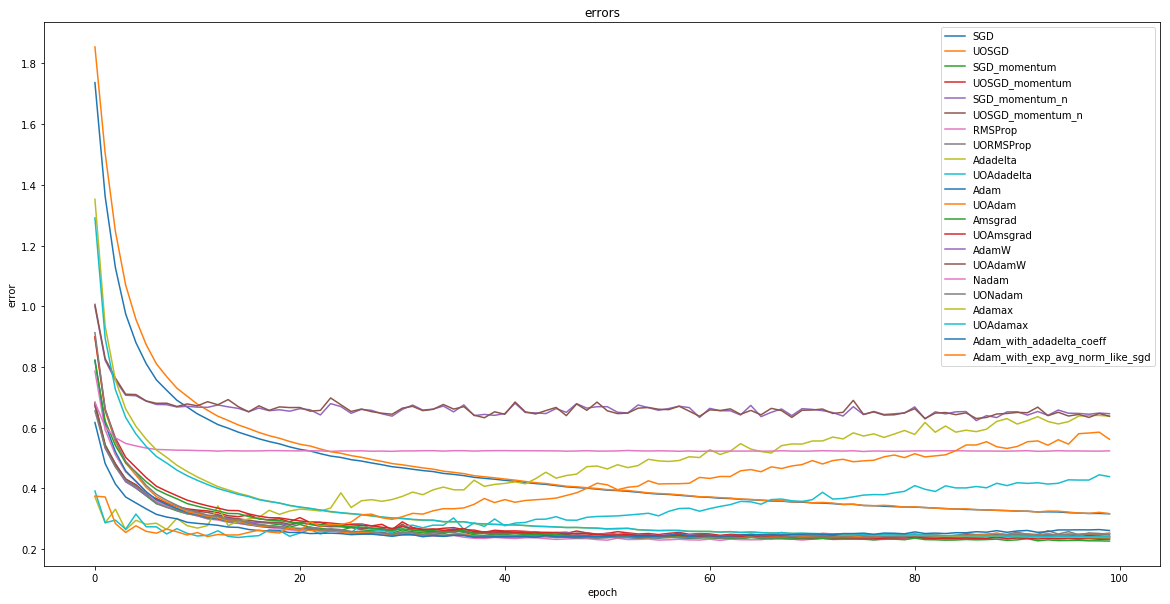

In [12]:
plot_graphs(test_log, 'loss', fs=(20, 10))

- Below we make a pairwise comparaison of standard algorithms and my implementation. Please note, that due to stochastic nature
of algorithms, the descent path could differ, but not too much. Exception for Nadam. For comparaison I use official implementation for Keras and it contains some hardcoded parameters that could not fit to any dataset. My implementation more classical and in case of this dataset looks better that Keras variant. 
- For better visualisation I excluded first 5 epochs, so below are the results from 6th epoch

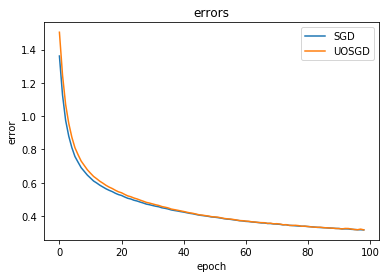

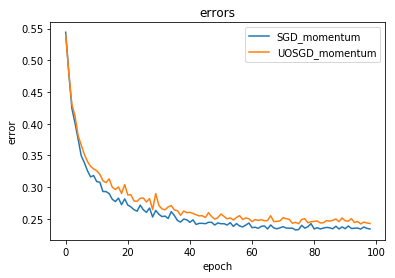

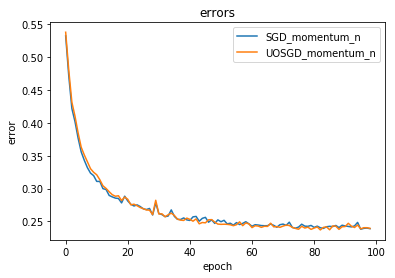

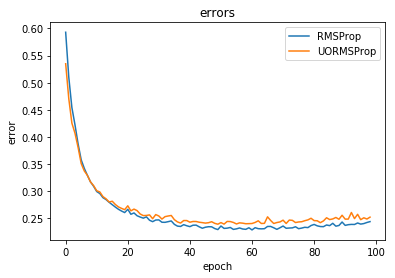

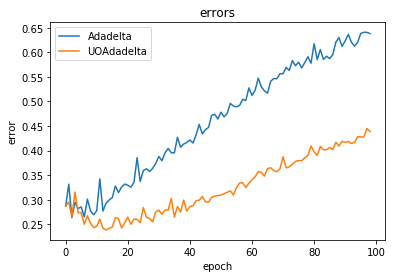

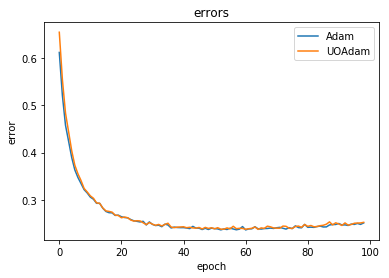

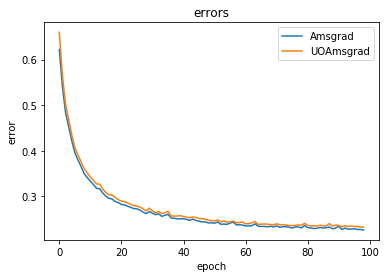

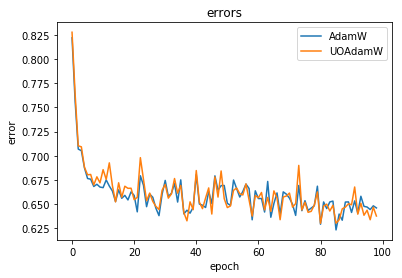

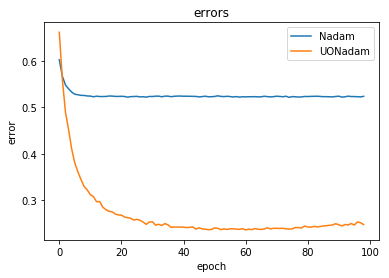

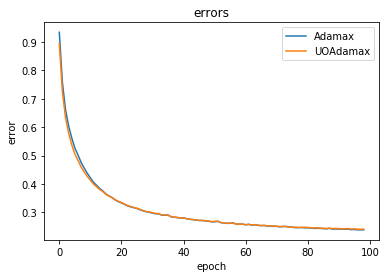

In [13]:
for i in ['SGD', 'SGD_momentum', 'SGD_momentum_n', 'RMSProp', 'Adadelta', 'Adam', 'Amsgrad', 'AdamW', 'Nadam', 'Adamax']:
    new_test_log = {}
    for k, v in test_log.items():
        if k == 'UO'+i or k==i:
            new_test_log[k] = v[1:]
    plot_graphs(new_test_log, 'loss')

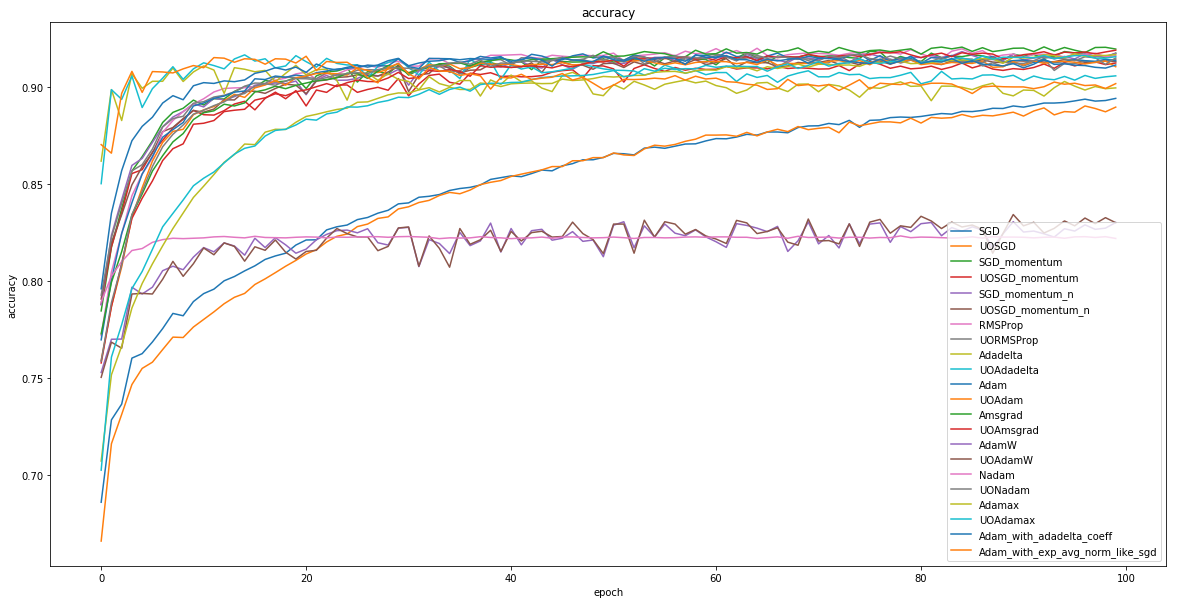

In [14]:
plot_graphs(test_log, 'accuracy', fs = (20, 10))

Now analyze dynamic of standard algorithms (we excluded the worst algos here like SGD, AdamW and Nadam). It looks like the best it is RMSProp here

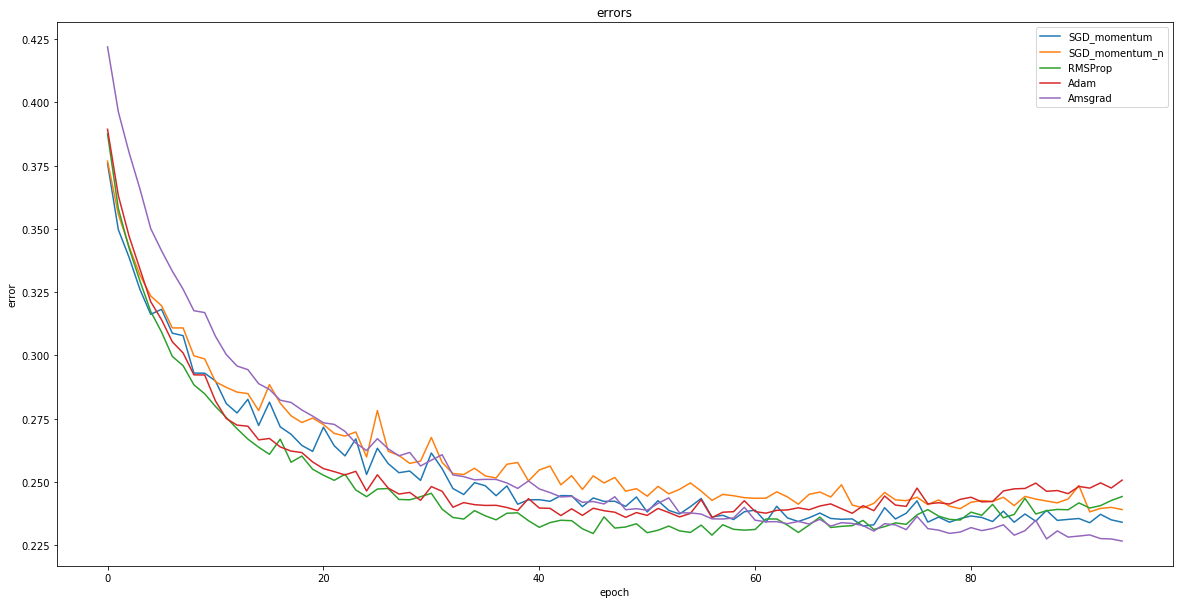

In [19]:
new_test_log = {}
for i in ['SGD_momentum', 'SGD_momentum_n', 'RMSProp', 'Adam', 'Amsgrad']:
    for k, v in test_log.items():
        if  k==i:
            new_test_log[k] = v[5:]
plot_graphs(new_test_log, 'loss', fs = (20, 10))

Lets compare RMSProp with the exotic combinations of our algorithm. **It looks like our exotic combination converge faster that the best standard algoritms during the first 40 epochs. Then standard algoritms continue to decrease the loss but in our version due to adadelta component, the loss began to increase and the results became worser**

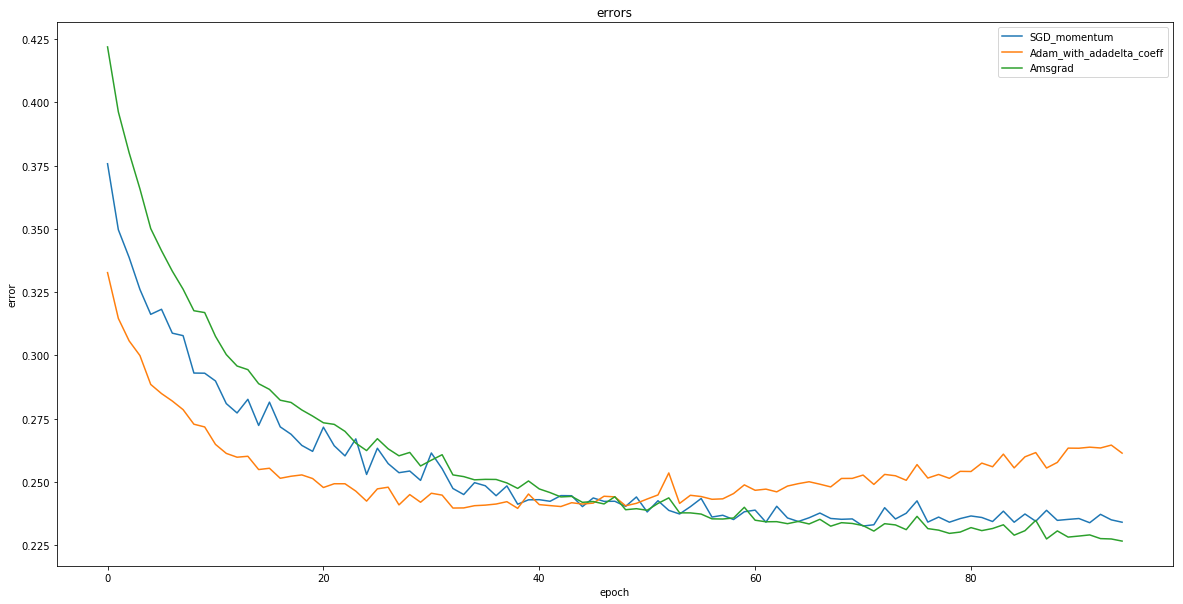

In [22]:
new_test_log = {}
for i in ['SGD_momentum','Adam_with_adadelta_coeff', 'Amsgrad']:
    for k, v in test_log.items():
        if  k==i:
            new_test_log[k] = v[5:]
plot_graphs(new_test_log, 'loss', fs = (20, 10))